In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from swmm_api import read_inp_file

c:\Users\chong\anaconda3\envs\storm\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from tensorflow.keras.losses import MeanSquaredError,CategoricalCrossentropy
mse = MeanSquaredError()
cce = CategoricalCrossentropy()

In [3]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, mean_absolute_percentage_error as mape,r2_score as r2,zero_one_loss as zo

# shunqing

In [59]:
cwd = './results/shunqing/5s_edge_res_norm_flood/'
files = [file for file in os.listdir(cwd) if file.endswith('.npy')]
events = list(set(['_'.join(file.split('_')[:2]) for file in files]))

In [60]:
from utilities import get_inp_files
from envs import get_env
env = get_env('shunqing')()
train_id = np.load('./model/shunqing/5s_20k_edge_res_norm_flood/train_id.npy')
events = get_inp_files(env.config['swmm_input'],env.config['rainfall'])
[event for idx,event in enumerate(events) if idx not in train_id]

['./envs/network/shunqing/bpswmm_63.inp',
 './envs/network/shunqing/bpswmm_66.inp',
 './envs/network/shunqing/bpswmm_69.inp',
 './envs/network/shunqing/bpswmm_611.inp',
 './envs/network/shunqing/bpswmm_616.inp',
 './envs/network/shunqing/bpswmm_715.inp',
 './envs/network/shunqing/bpswmm_718.inp',
 './envs/network/shunqing/bpswmm_722.inp',
 './envs/network/shunqing/bpswmm_725.inp',
 './envs/network/shunqing/bpswmm_84.inp',
 './envs/network/shunqing/bpswmm_814.inp',
 './envs/network/shunqing/bpswmm_819.inp',
 './envs/network/shunqing/bpswmm_823.inp',
 './envs/network/shunqing/bpswmm_94.inp',
 './envs/network/shunqing/bpswmm_96.inp',
 './envs/network/shunqing/bpswmm_914.inp',
 './envs/network/shunqing/bpswmm_101.inp',
 './envs/network/shunqing/bpswmm_102.inp',
 './envs/network/shunqing/bpswmm_105.inp',
 './envs/network/shunqing/bpswmm_1017.inp',
 './envs/network/shunqing/bpswmm_112.inp',
 './envs/network/shunqing/bpswmm_115.inp',
 './envs/network/shunqing/bpswmm_131.inp',
 './envs/network

In [62]:
event = 'bpswmm_2413'
inp = read_inp_file('./envs/network/shunqing/'+event+'.inp')
interval = inp.RAINGAGES[env.config['rainfall']['gage']].Interval
interval = eval(interval.split(':')[0])*60 + eval(interval.split(':')[1])
rain = [dat[-1] for dat in inp.TIMESERIES[event].data]
rain_ind = [interval*idx for idx in range(len(rain))]

## Nodes

In [30]:
event = 'bpswmm_2413'
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
err = true - pred


In [31]:
inp = read_inp_file('./envs/network/shunqing/'+event+'.inp')
interval = inp.RAINGAGES[env.config['rainfall']['gage']].Interval
interval = eval(interval.split(':')[0])*60 + eval(interval.split(':')[1])
rain = [dat[-1] for dat in inp.TIMESERIES[event].data]
rain_ind = [interval*idx for idx in range(len(rain))]

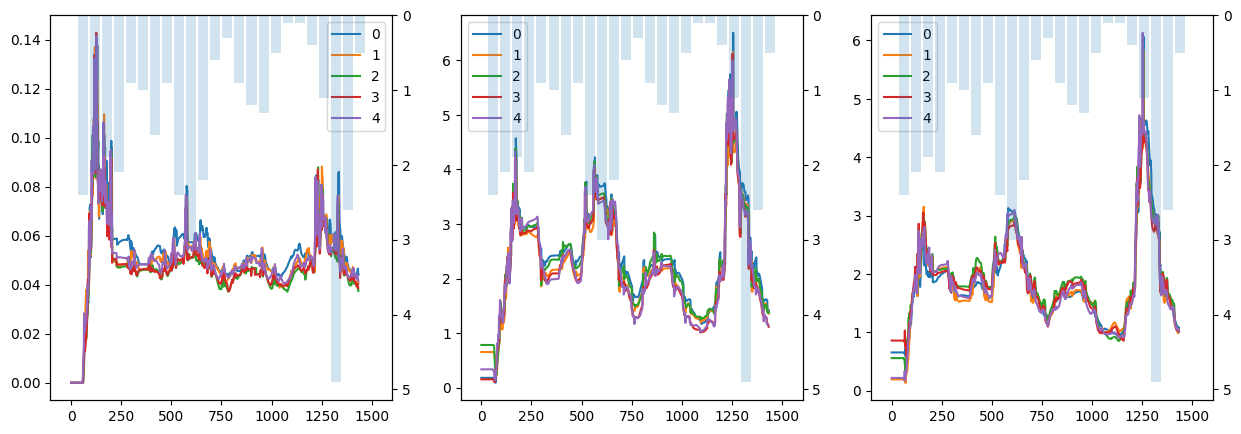

In [32]:
# true = np.load(os.path.join(cwd,event+'_true.npy'))
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()
    ax2 = ax.twinx()
    ax2.invert_yaxis()
    ax2.bar(rain_ind,rain,width=50,alpha=0.2)

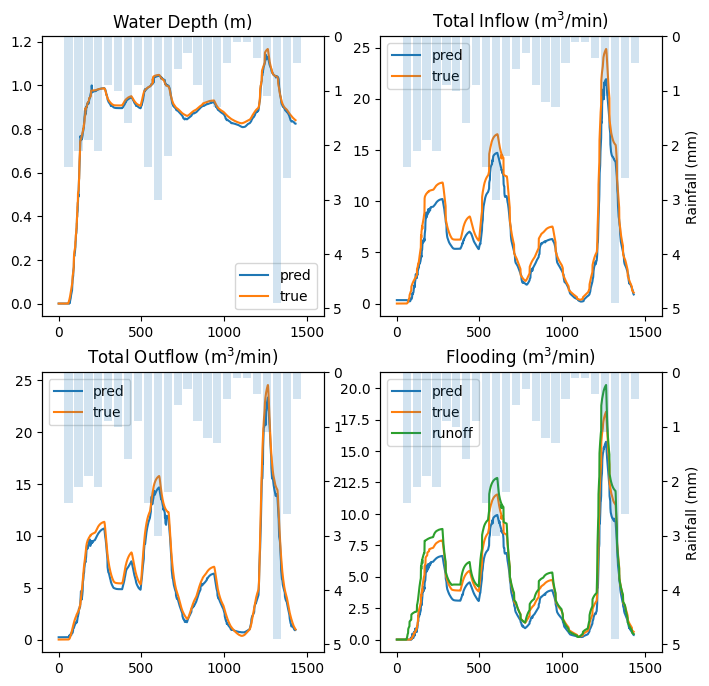

In [33]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = -1
axes = [ax1,ax2,ax3,ax4]
titles = ['Water Depth (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    if idx == len(axes)-1:
        idx = -1
    ax.plot(pred[:,seq,...].mean(axis=1)[:,idx],label='pred')
    ax.plot(true[:,seq,...].mean(axis=1)[:,idx],label='true')
    if idx == -1:
        ax.plot(r[:,seq,...].mean(axis=1),label='runoff')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=50,alpha=0.2)
    if idx in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')

In [58]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = pd.MultiIndex.from_tuples([(a,b) for a in columns for b in metrics]))
for i in [0,1,2,-1]:
    for j,metric in enumerate([mse,mae,r2]):
        results[columns[i],metrics[j]] = [metric(true[:,idx,:,i],pred[:,idx,:,i]) for idx in range(true.shape[1])]
results[[(a,'RMSE') for a in columns]] = np.sqrt(results[[(a,'RMSE') for a in columns]].to_numpy())
results[('Total inflow','R2')] = [metric(true[:,idx,:,1][:,np.abs(true[:,idx,:,1]).max(axis=0)>1e-6],pred[:,idx,:,1][:,np.abs(true[:,idx,:,1]).max(axis=0)>1e-6]) for idx in range(true.shape[1])]
results

Water depth                     Total inflow                      \
         RMSE       MAE        R2         RMSE       MAE        R2   
0    0.006644  0.003242  0.993362     1.174963  0.436554  0.703848   
1    0.006321  0.002946  0.993777     1.168937  0.431320  0.701380   
2    0.006053  0.003006  0.993704     1.171686  0.431890  0.700305   
3    0.006118  0.003064  0.993922     1.173586  0.433392  0.699343   
4    0.006249  0.002991  0.994861     1.178861  0.436534  0.701124   

  Total outflow                      Flooding                      
           RMSE       MAE        R2      RMSE       MAE        R2  
0      0.373681  0.162605  0.987895  0.179623  0.008959  0.998311  
1      0.374655  0.160601  0.987525  0.180843  0.009421  0.998288  
2      0.370219  0.157997  0.988317  0.183874  0.009318  0.998230  
3      0.367775  0.158446  0.988341  0.184677  0.009188  0.998215  
4      0.362660  0.159038  0.988358  0.184737  0.009137  0.998214

In [35]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],true.shape[-1]))
for i in [0,1,2,-1]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[...,i],y_pred[...,i],squared=False) if metric == mse else metric(y_true[...,i],y_pred[...,i])
# results.loc['R2','Water depth'] = metric(y_true[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-6],y_pred[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-6])
results.loc['R2','Total inflow'] = metric(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6],y_pred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6])
# results.loc['R2','Flooding'] = metric(y_true[...,-1][:,np.abs(y_true[...,-1]).max(axis=0)>1e-6],y_pred[...,-1][:,np.abs(y_true[...,-1]).max(axis=0)>1e-6])
results

,Water depth,Total inflow,Total outflow,Flooding
RMSE,0.080015,2.822591,2.393149,1.320655
MAE,0.04942,2.257764,1.828575,1.002607
R2,-1.364558,0.115466,0.139695,0.848349


- Select a Node to plot, what is the outlet boundary?
- Cannot predict water level of a specific node precisely
    - Possibly because it depends on both up and downstream
    - Or it can be better if nodes have storage volumes: not significant
    - Water level error makes up with small loss: Normalization works
- Cannot Predict flooding precisely
    - Classify flooding or not: It works!!!

#### Element-wise

In [246]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/shunqing/shunqing.inp')
nodes = [k for k in inp.JUNCTIONS]

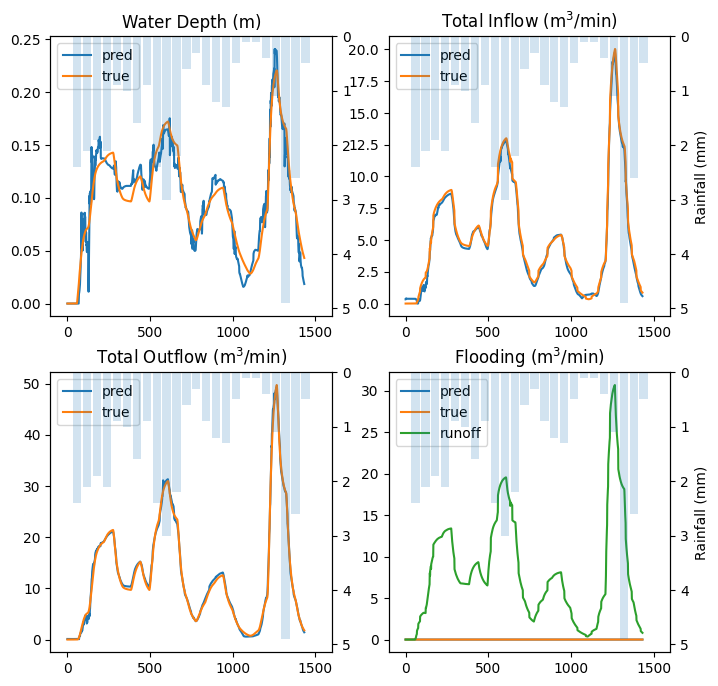

In [247]:
idx = nodes.index('jd27')
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = -1
axes = [ax1,ax2,ax3,ax4]
titles = ['Water Depth (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for i,(ax,title) in enumerate(zip(axes,titles)):
    if i == len(axes)-1:
        i = -1
    ax.plot(pred[:,seq,idx,i],label='pred')
    ax.plot(true[:,seq,idx,i],label='true')
    if i == -1:
        ax.plot(r[:,seq,idx,0],label='runoff')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=50,alpha=0.2)
    if i in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')

In [248]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],true.shape[-1]))
for i in [0,1,2,-1]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[:,idx,i],y_pred[:,idx,i],squared=False) if metric == 'RMSE' else metric(y_true[:,idx,i],y_pred[:,idx,i])
results.loc['R2','Total inflow'] = metric(y_true[:,idx,1][:,np.abs(y_true[:,idx,1]).max(axis=0)>1e-6],y_pred[:,idx,1][:,np.abs(y_true[:,idx,1]).max(axis=0)>1e-6])
results

,Water depth,Total inflow,Total outflow,Flooding
RMSE,0.000193,0.125643,0.333861,0.0
MAE,0.011043,0.290736,0.424861,0.0
R2,0.914229,0.993373,0.996952,1.0


## Edges

In [36]:
event = 'bpswmm_2413'
true = np.load(os.path.join(cwd,event+'_edge_true.npy'))
pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
err = true - pred
err.shape

(1434, 5, 131, 3)

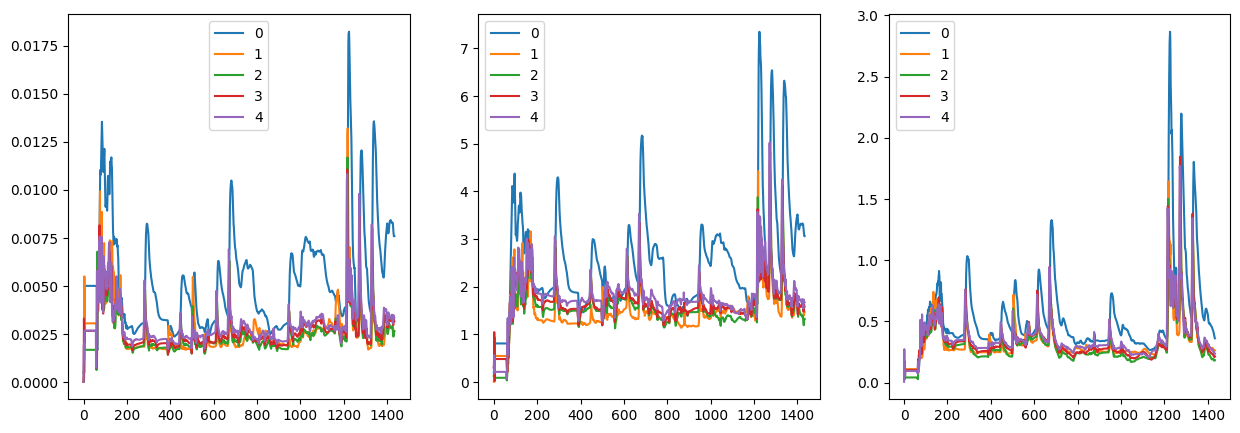

In [37]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()

Text(0, 0.5, 'Rainfall (mm)')

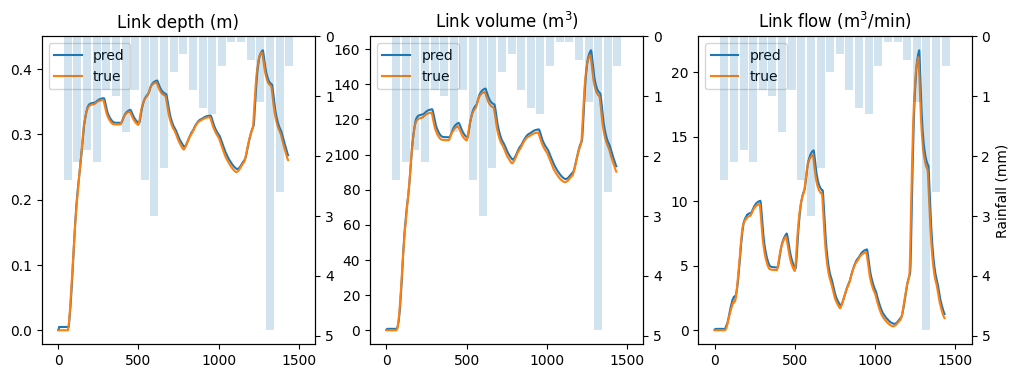

In [38]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
seq = 0

axes = [ax1,ax2,ax3]
titles = ['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    ax.plot(pred[:,seq,...].mean(axis=1)[:,idx],label='pred')
    ax.plot(true[:,seq,...].mean(axis=1)[:,idx],label='true')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=50,alpha=0.2)
axx.set_ylabel('Rainfall (mm)')



In [39]:
columns = ['Link depth','Link volume','Link flow']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],true.shape[-1]))
for i in [0,1,2]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[...,i],y_pred[...,i],squared=False) if metric == mse else metric(y_true[...,i],y_pred[...,i])
results.loc['R2','Link depth'] = r2(y_true[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-6],y_pred[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-6])
results.loc['R2','Link volume'] = r2(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6],y_pred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6])
results

,Link depth,Link volume,Link flow
RMSE,0.005007,2.345153,0.562051
MAE,0.003248,1.798846,0.376665
R2,0.995083,0.992616,0.95384


#### Element-wise

In [257]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/shunqing/shunqing.inp')
links = [k for k in list(inp.CONDUITS)]


Text(0, 0.5, 'Rainfall (mm)')

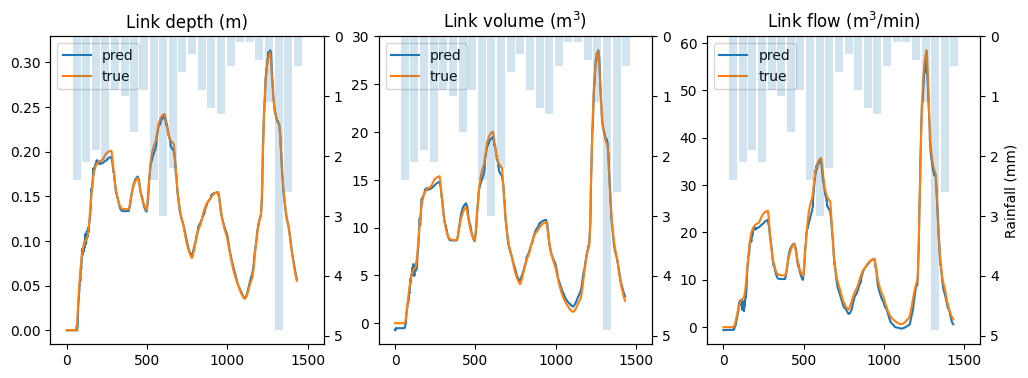

In [258]:
seq = -1
idx = links.index('GQ76')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))

axes = [ax1,ax2,ax3]
titles = ['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']
for i,(ax,title) in enumerate(zip(axes,titles)):
    ax.plot(pred[:,seq,idx,i],label='pred')
    ax.plot(true[:,seq,idx,i],label='true')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=50,alpha=0.2)
axx.set_ylabel('Rainfall (mm)')


In [259]:
columns = ['Link depth','Link volume','Link flow']
metrics = ['RMSE','MAE','R2']
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],true.shape[-1]))
results = pd.DataFrame(columns = columns)
for i in [0,1,2]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[:,idx,i],y_pred[:,idx,i],squared=False) if metric == 'RMSE' else metric(y_true[:,idx,i],y_pred[:,idx,i])
results

,Link depth,Link volume,Link flow
RMSE,0.000011,0.141616,1.251363
MAE,0.002555,0.305213,0.955956
R2,0.997543,0.996368,0.99171


## Node-edge fusion comparison

In [41]:
event = 'bpswmm_2413'
cwd = './results/shunqing/5s_edge_res_norm_flood/'
true = np.load(os.path.join(cwd,event+'_true.npy'))
edge_true = np.load(os.path.join(cwd,event+'_edge_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
edge_pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
fpred = np.load(os.path.join(cwd.replace('edge','edgef'),event+'_pred.npy'))
edge_fpred = np.load(os.path.join(cwd.replace('edge','edgef'),event+'_edge_pred.npy'))

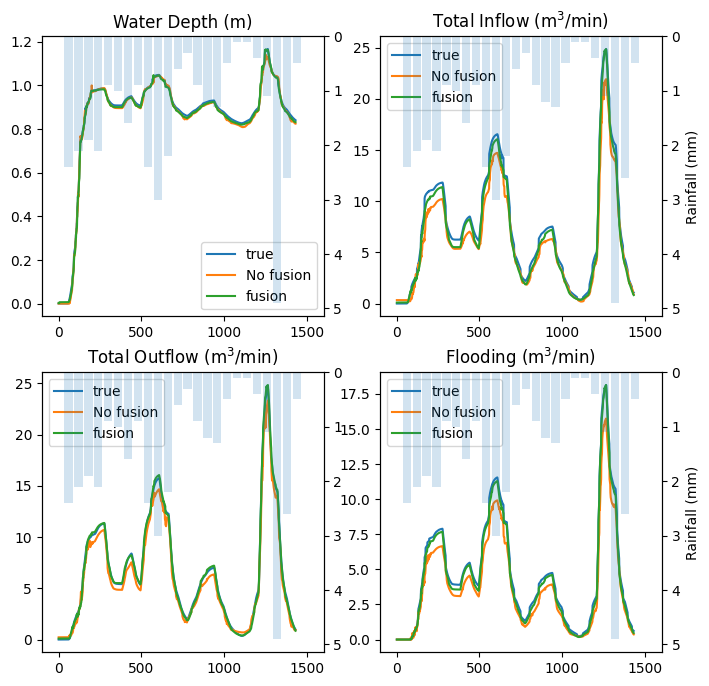

In [44]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = -1
axes = [ax1,ax2,ax3,ax4]
titles = ['Water Depth (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    if idx == len(axes)-1:
        idx = -1
    ax.plot(true[:,seq,...].mean(axis=1)[:,idx],label='true')
    ax.plot(pred[:,seq,...].mean(axis=1)[:,idx],label='No fusion')
    ax.plot(fpred[:,seq,...].mean(axis=1)[:,idx],label='fusion')
    # if idx == -1:
    #     ax.plot(r[:,seq,...].mean(axis=1),label='runoff')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=50,alpha=0.2)
    if idx in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')

In [50]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],pred.shape[-1]))
y_fpred = np.reshape(fpred,(-1,fpred.shape[-2],fpred.shape[-1]))
for i in [0,1,2,-1]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j]+' No fusion',columns[i]] = metric(y_true[...,i],y_pred[...,i],squared=False) if metrics[j] == 'RMSE' else metric(y_true[...,i],y_pred[...,i])
        results.loc[metrics[j]+' fusion',columns[i]] = metric(y_true[...,i],y_fpred[...,i],squared=False) if metrics[j] == 'RMSE' else metric(y_true[...,i],y_fpred[...,i])

# results.loc['R2','Water depth'] = metric(y_true[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-6],y_pred[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-6])
results.loc['R2 No fusion','Total inflow'] = metric(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6],y_pred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6])
results.loc['R2 fusion','Total inflow'] = metric(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6],y_fpred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6])
# results.loc['R2','Flooding'] = metric(y_true[...,-1][:,np.abs(y_true[...,-1]).max(axis=0)>1e-6],y_pred[...,-1][:,np.abs(y_true[...,-1]).max(axis=0)>1e-6])
results

,Water depth,Total inflow,Total outflow,Flooding
RMSE No fusion,0.080015,2.822591,2.393149,1.320655
RMSE fusion,0.029779,0.660964,0.504255,0.345742
MAE No fusion,0.04942,2.257764,1.828575,1.002607
MAE fusion,0.015408,0.53044,0.370131,0.254325
R2 No fusion,-1.364558,0.115466,0.139695,0.848349
R2 fusion,0.868653,0.959091,0.970581,-0.372233


Text(0, 0.5, 'Rainfall (mm)')

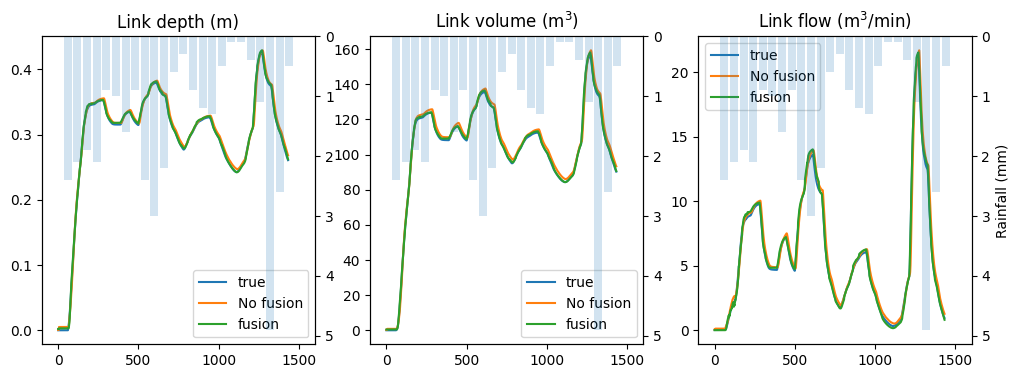

In [46]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
seq = 0

axes = [ax1,ax2,ax3]
titles = ['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    ax.plot(edge_true[:,seq,...].mean(axis=1)[:,idx],label='true')
    ax.plot(edge_pred[:,seq,...].mean(axis=1)[:,idx],label='No fusion')
    ax.plot(edge_fpred[:,seq,...].mean(axis=1)[:,idx],label='fusion')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=50,alpha=0.2)
axx.set_ylabel('Rainfall (mm)')


In [52]:
columns = ['Link depth','Link volume','Link flow']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(edge_true,(-1,edge_true.shape[-2],edge_true.shape[-1]))
y_pred = np.reshape(edge_pred,(-1,edge_pred.shape[-2],edge_pred.shape[-1]))
y_fpred = np.reshape(edge_fpred,(-1,edge_fpred.shape[-2],edge_fpred.shape[-1]))
for i in [0,1,2]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j]+' No fusion',columns[i]] = metric(y_true[...,i],y_pred[...,i],squared=False) if metric == mse else metric(y_true[...,i],y_pred[...,i])
        results.loc[metrics[j]+' fusion',columns[i]] = metric(y_true[...,i],y_fpred[...,i],squared=False) if metric == mse else metric(y_true[...,i],y_fpred[...,i])
results.loc['R2 No fusion','Link depth'] = r2(y_true[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-6],y_pred[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-6])
results.loc['R2 fusion','Link depth'] = r2(y_true[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-6],y_fpred[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-6])
results.loc['R2 No fusion','Link volume'] = r2(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6],y_pred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6])
results.loc['R2 fusion','Link volume'] = r2(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6],y_fpred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6])
results

,Link depth,Link volume,Link flow
RMSE No fusion,0.005007,2.345153,0.562051
RMSE fusion,0.004733,1.726121,0.500949
MAE No fusion,0.003248,1.798846,0.376665
MAE fusion,0.003575,1.31552,0.377601
R2 No fusion,0.995083,0.992616,0.95384
R2 fusion,0.9955,0.994983,0.952534


## Flood determination

In [106]:
event = 'bpswmm_2413'
cwd = './results/shunqing/5s_edgef_res_norm/'
true = np.load(os.path.join(cwd.replace('_norm','_norm_flood'),event+'_true.npy'))
edge_true = np.load(os.path.join(cwd.replace('_norm','_norm_flood'),event+'_edge_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
edge_pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
bpred = np.load(os.path.join(cwd.replace('_norm','_norm_bal'),event+'_pred.npy'))
edge_bpred = np.load(os.path.join(cwd.replace('_norm','_norm_bal'),event+'_edge_pred.npy'))
fpred = np.load(os.path.join(cwd.replace('_norm','_norm_flood'),event+'_pred.npy'))
edge_fpred = np.load(os.path.join(cwd.replace('_norm','_norm_flood'),event+'_edge_pred.npy'))

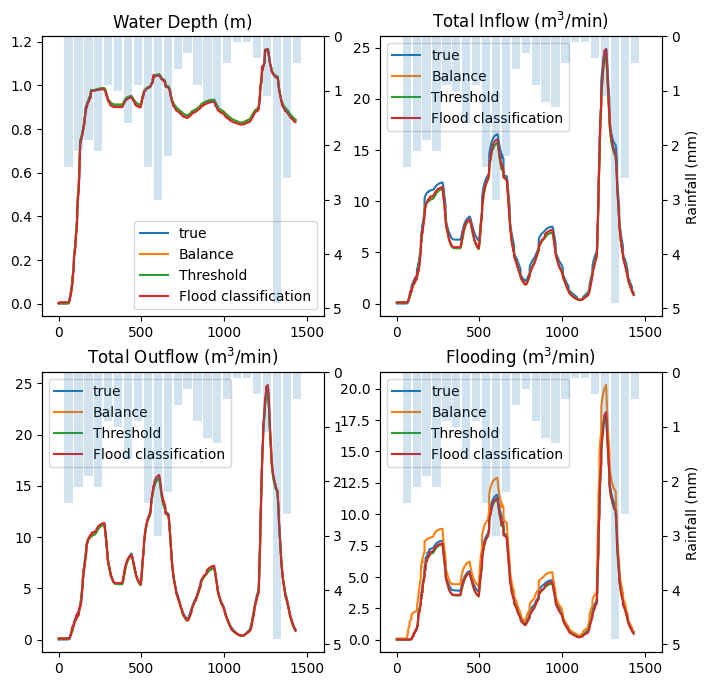

In [107]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = -1
axes = [ax1,ax2,ax3,ax4]
titles = ['Water Depth (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    if idx == len(axes)-1:
        idx = -1
    ax.plot(true[:,seq,...].mean(axis=1)[:,idx],label='true')
    ax.plot(bpred[:,seq,...].mean(axis=1)[:,idx],label='Balance')
    ax.plot(pred[:,seq,...].mean(axis=1)[:,idx],label='Threshold')
    ax.plot(fpred[:,seq,...].mean(axis=1)[:,idx],label='Flood classification')
    # if idx == -1:
    #     ax.plot(r[:,seq,...].mean(axis=1),label='runoff')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=50,alpha=0.2)
    if idx in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')

Text(0, 0.5, 'Rainfall (mm)')

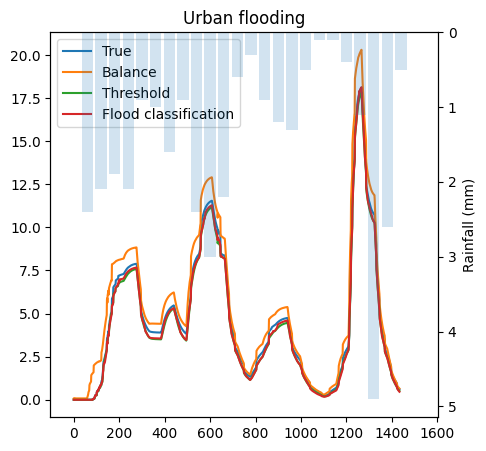

In [108]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(true[:,seq,...].mean(axis=1)[:,-1],label='True')
ax.plot(bpred[:,seq,...].mean(axis=1)[:,-1],label='Balance')
ax.plot(pred[:,seq,...].mean(axis=1)[:,-1],label='Threshold')
ax.plot(fpred[:,seq,...].mean(axis=1)[:,-1],label='Flood classification')
ax.legend()
ax.set_title('Urban flooding')
axx = ax.twinx()
axx.invert_yaxis()
axx.bar(rain_ind,rain,width=50,alpha=0.2)
axx.set_ylabel('Rainfall (mm)')

In [109]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],pred.shape[-1]))
y_bpred = np.reshape(bpred,(-1,bpred.shape[-2],bpred.shape[-1]))
y_fpred = np.reshape(fpred,(-1,fpred.shape[-2],fpred.shape[-1]))
for i in [0,1,2,-1]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j]+' Balance',columns[i]] = metric(y_true[...,i],y_bpred[...,i],squared=False) if metrics[j] == 'RMSE' else metric(y_true[...,i],y_bpred[...,i])
        results.loc[metrics[j]+' Threshold',columns[i]] = metric(y_true[...,i],y_pred[...,i],squared=False) if metrics[j] == 'RMSE' else metric(y_true[...,i],y_pred[...,i])
        results.loc[metrics[j]+' Classification',columns[i]] = metric(y_true[...,i],y_fpred[...,i],squared=False) if metrics[j] == 'RMSE' else metric(y_true[...,i],y_fpred[...,i])

# results.loc['R2','Water depth'] = metric(y_true[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-6],y_pred[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-6])
results.loc['R2 Balance','Total inflow'] = metric(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6],y_bpred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6])
results.loc['R2 Threshold','Total inflow'] = metric(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6],y_pred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6])
results.loc['R2 Classification','Total inflow'] = metric(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6],y_fpred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6])
# results.loc['R2','Flooding'] = metric(y_true[...,-1][:,np.abs(y_true[...,-1]).max(axis=0)>1e-6],y_pred[...,-1][:,np.abs(y_true[...,-1]).max(axis=0)>1e-6])
results

,Water depth,Total inflow,Total outflow,Flooding
RMSE Balance,0.014199,0.735797,0.339251,1.805439
RMSE Threshold,0.014199,0.735797,0.339251,0.363388
RMSE Classification,0.029779,0.660964,0.504255,0.345742
MAE Balance,0.00547,0.630993,0.266142,1.294221
MAE Threshold,0.00547,0.630993,0.266142,0.288657
MAE Classification,0.015408,0.53044,0.370131,0.254325
R2 Balance,0.973806,0.954273,0.97952,-107.223383
R2 Threshold,0.973806,0.954273,0.97952,0.673875
R2 Classification,0.868653,0.959091,0.970581,-0.372233


In [113]:
from sklearn.metrics import accuracy_score,precision_score,recall_score
l_true = np.argmax(true[...,-3:-1],axis=-1).flatten()
l_bpred = (bpred[...,-1]>0).astype(np.int64).flatten()
l_pred = (pred[...,-1]>0).astype(np.int64).flatten()
l_fpred = np.argmax(fpred[...,-3:-1],axis=-1).flatten()
results = pd.DataFrame(columns = ['Balance','Threshold','Classification'])
for met,metric in zip(['Accuracy','Precision','Recall'],[accuracy_score,precision_score,recall_score]):
    results.loc[met] = [metric(l_true,l_p) for l_p in [l_bpred,l_pred,l_fpred]]
results.round(4)

,Balance,Threshold,Classification
Accuracy,0.4048,0.9980,0.9994
Precision,0.2735,0.9929,0.9984
Recall,0.9996,0.9983,0.9992


In [112]:
from sklearn.metrics import confusion_matrix
confusion_matrix(l_true,l_bpred).ravel(),confusion_matrix(l_true,l_pred).ravel(),confusion_matrix(l_true,l_fpred).ravel()

(array([146494, 482136,     64, 181516], dtype=int64),
 array([627325,   1305,    305, 181275], dtype=int64),
 array([628334,    296,    151, 181429], dtype=int64))

## Debug

### Debug inflow & outflow

In [23]:
import numpy as np
event_id = np.load('./envs/data/shunqing/edge/event_id.npy')
edge_states = np.load('./envs/data/shunqing/edge/edge_states.npy')[event_id==0]
states = np.load('./envs/data/shunqing/edge/states.npy')[event_id==0]


In [4]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/shunqing/shunqing.inp')
nodes = [k for k in list(inp.JUNCTIONS)+list(inp.OUTFALLS)]
idx = nodes.index('jd30')
edges = [k for k in list(inp.CONDUITS)]
idxe = [edges.index(e) for e in ['GQ16','GQ38','GQ75','GQ73']]

In [5]:
import pandas as pd
jd = pd.DataFrame()
jd['tot_in'],jd['tot_out'],jd['lat_in'] = states[:,idx,1],states[:,idx,2],states[:,idx,3]
links = ['GQ16','GQ38','GQ75','GQ73']
jd[links] = np.array([edge_states[:,e,-1] for e in idxe]).T
jd

,tot_in,tot_out,lat_in,GQ16,GQ38,GQ75,GQ73
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
396,4.263206,4.008364,1.610603,2.526705,-0.403256,0.661647,2.943461
397,4.275959,4.026690,1.614094,2.538565,-0.404979,0.664665,2.957045
398,4.288628,4.044597,1.617667,2.550150,-0.406663,0.667615,2.970319
399,4.301039,4.062131,1.621246,2.561484,-0.408312,0.670503,2.983316


In [18]:
jd['GQ73']+jd['GQ75'] - jd['tot_out']

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
396   -0.403256
397   -0.404979
398   -0.406663
399   -0.408312
400   -0.409168
Length: 401, dtype: float64

### Inverse conduits

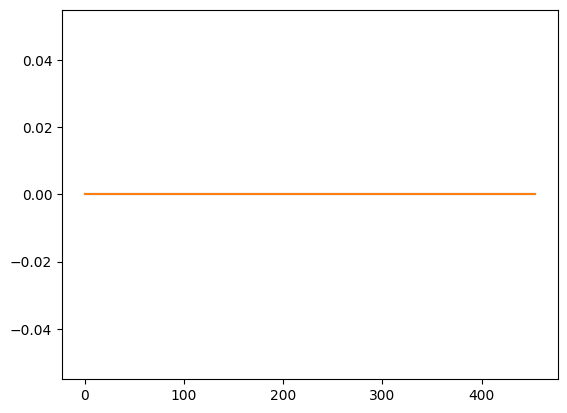

In [27]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/shunqing/shunqing.inp')
edges = np.array([k for k in list(inp.CONDUITS)])
import numpy as np
event_id = np.load('./envs/data/shunqing/edge/event_id.npy')
edge_states = np.load('./envs/data/shunqing/edge/edge_states.npy')[event_id==0]
flow = edge_states[...,-2]
inv_edges_idx = (1-np.sum(flow>0,axis=0)>0).nonzero()
for idx in inv_edges_idx:
    plt.plot(flow[:,idx])

In [28]:
edges[inv_edges_idx]

array(['GQ77', 'GQ120'], dtype='<U5')

In [148]:
(1-np.sum(flow>0,axis=0)>0).nonzero()[0]

array([  1,   4,   5,   8,  11,  16,  19,  21,  22,  23,  26,  27,  32,
        36,  37,  40,  46,  47,  48,  49,  52,  54,  57,  60,  61,  64,
        68,  76,  77,  79,  84,  85,  86,  87,  94,  97, 102, 103, 105,
       106, 107, 109, 115, 119, 121, 123, 129, 130], dtype=int64)

In [147]:
(np.sum(flow<0,axis=0)>0).nonzero()[0]

array([  1,   4,   5,   8,  11,  16,  17,  19,  21,  22,  23,  26,  27,
        28,  32,  36,  37,  40,  46,  47,  48,  49,  52,  54,  57,  59,
        60,  61,  64,  66,  68,  77,  78,  79,  84,  85,  86,  87,  94,
        97, 102, 103, 104, 105, 106, 107, 109, 113, 115, 120, 121, 123,
       129, 130], dtype=int64)

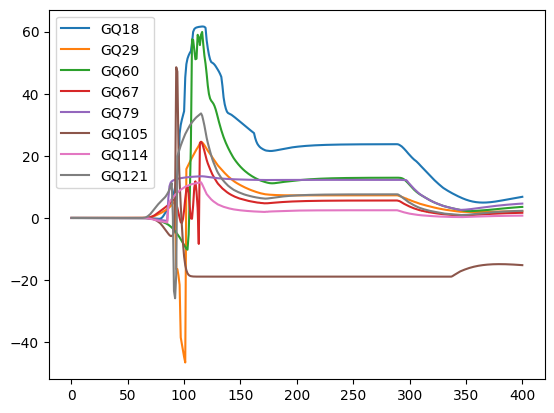

In [153]:
idxs = [idx for idx in (np.sum(flow<0,axis=0)>0).nonzero()[0] if idx not in (1-np.sum(flow>0,axis=0)>0).nonzero()[0]]
for idx in idxs:
    plt.plot(flow[:,idx],label = edges[idx])
plt.legend()

In [157]:
for edge in edges[inv_edges_idx].tolist()+['GQ105']:
    cond = inp['CONDUITS'][edge]
    cond.FromNode,cond.ToNode = cond.ToNode,cond.FromNode
    cond.InOffset,cond.OutOffset = cond.OutOffset,cond.InOffset

In [159]:
inp.write_file('./envs/network/shunqing/shunqing.inp')

'./envs/network/shunqing/shunqing.inp'

### Debug inflow & flow

In [245]:
from envs import get_env
env = get_env('shunqing')()
node_edge = env.get_args()['node_edge']

In [305]:
edge_true = np.load('./results/shunqing/5s_edge_res_norm_flood/bpswmm_2412_edge_true.npy')
true = np.load('./results/shunqing/5s_edge_res_norm_flood/bpswmm_2412_true.npy')
node_outflow = np.matmul(np.clip(node_edge,0,1),np.clip(edge_true[...,-1:],0,np.inf)) + np.matmul(np.abs(np.clip(node_edge,-1,0)),-np.clip(edge_true[...,-1:],-np.inf,0))
node_inflow = np.matmul(np.abs(np.clip(node_edge,-1,0)),np.clip(edge_true[...,-1:],0,np.inf)) + np.matmul(np.clip(node_edge,0,1),-np.clip(edge_true[...,-1:],-np.inf,0))

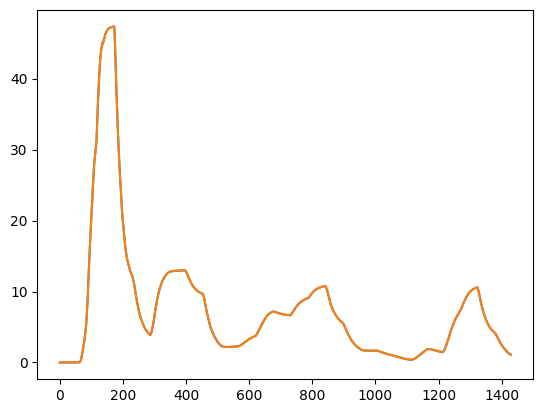

In [306]:
plt.plot(node_outflow[:,0,:,0].mean(axis=1))
plt.plot(true[:,0,:,2].mean(axis=1))

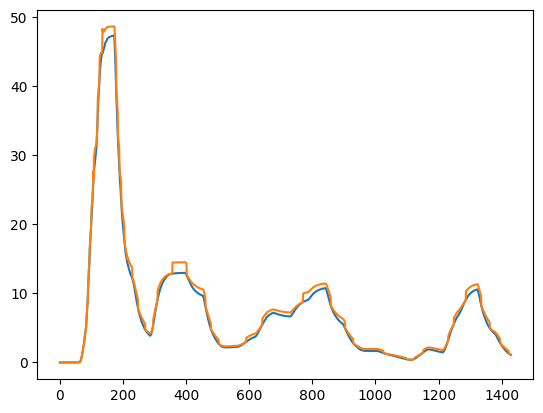

In [307]:
plt.plot(node_inflow[:,0,:,0].mean(axis=1))
plt.plot(true[:,0,:,1].mean(axis=1))

In [327]:
edge_pred = np.load('./results/shunqing/5s_edge_res_norm_flood/bpswmm_2412_edge_pred.npy')
pred = np.load('./results/shunqing/5s_edge_res_norm_flood/bpswmm_2412_pred.npy')
node_outflow = np.matmul(np.clip(node_edge,0,1),np.clip(edge_pred[...,-1:],0,np.inf))
node_inflow = np.matmul(np.abs(np.clip(node_edge,-1,0)),np.clip(edge_pred[...,-1:],0,np.inf))

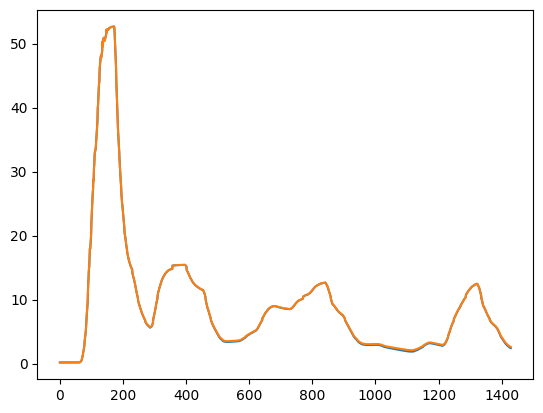

In [328]:
plt.plot(node_outflow[:,0,:,0].mean(axis=1))
plt.plot(pred[:,0,:,2].mean(axis=1))

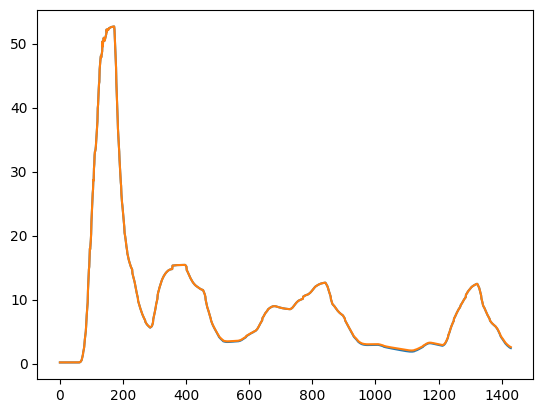

In [329]:
plt.plot(node_inflow[:,0,:,0].mean(axis=1))
plt.plot(pred[:,0,:,1].mean(axis=1))

## Train loss

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [30]:
cwd = './model/shunqing/5s_20k_edge_res_norm_flood/'
train_losses = np.load(os.path.join(cwd,'train_loss.npy'))
test_losses = np.load(os.path.join(cwd,'test_loss.npy'))
train_ids = np.load(os.path.join(cwd,'train_id.npy'))
test_ids = np.load(os.path.join(cwd,'test_id.npy'))

In [5]:
train_ids

array([108,  55,   3,  43, 146,  19, 125,   3, 135,  58,   1,  71,  26,
        78, 130,  76,  54, 111, 123, 121,  99, 135, 141, 130,   5, 124,
         6,  25,  50, 127,   6,   2, 104,  77,  86, 141, 116,  18,  13,
        76,  91,  12, 123, 130,  19,  64,  72,  96,  77,  67,   3,  68,
        29,   7, 122,  76, 127,  14,  11,  55,  46,  91,  20, 124,  89,
        31,   7,  23,  80,   6,  46,  20,  69, 137,  77, 100,   5,  37,
         7,  22,  96,  79, 108,  90,  97,  38, 130, 133,  33, 118,  88,
       101,  79,  48, 142, 122,  84,  38,  98,  66, 132,  74,  18,  87,
        33,  38,  33,  26,   0,  41,  95,  68,  69,  58, 119,  53,  81,
       121])

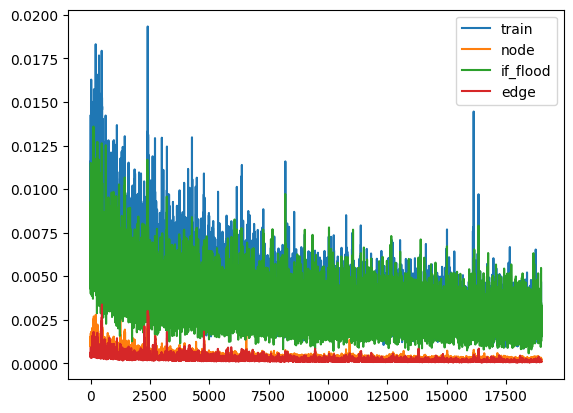

In [31]:
plt.plot(train_losses[1000:],label='train')
plt.plot(test_losses[1000:],label=['node','if_flood','edge'])
# plt.plot([sum(los) for los in test_losses[1000:]],label='test')
plt.legend()

# RedChicoSur

## Prediction

In [260]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [261]:
cwd = './results/RedChicoSur/5s_20k_edge_res_norm_flood/'
files = [file for file in os.listdir(cwd) if file.endswith('.npy')]
events = list(set(['_'.join(file.split('_')[:2]) for file in files]))

In [262]:
from utilities import get_inp_files
from envs import get_env
env = get_env('RedChicoSur')()
train_id = np.load('./model/RedChicoSur/5s_20k_edge_res_norm_flood/train_id.npy')
events = get_inp_files(env.config['swmm_input'],env.config['rainfall'])
[event for idx,event in enumerate(events) if idx not in train_id]

['./envs/network/RedChicoSur/08_08_14.inp',
 './envs/network/RedChicoSur/eval_0.inp',
 './envs/network/RedChicoSur/train_0.inp',
 './envs/network/RedChicoSur/train_11.inp',
 './envs/network/RedChicoSur/train_17.inp',
 './envs/network/RedChicoSur/train_9.inp']

### Nodes

In [263]:
event = 'train_0'
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
err = true - pred
err.shape

(342, 5, 443, 6)

In [264]:
inp = read_inp_file('./envs/network/RedChicoSur/'+event+'.inp')
gage = inp.RAINGAGES[env.config['rainfall']['gage']]
interval = int(gage.Interval.split(':')[0])*60 + int(gage.Interval.split(':')[1])
rain = [dat[-1] for dat in inp.TIMESERIES[event].data]
if gage.Format =='CUMULATIVE':
    rain = np.diff(rain)
rain_ind = [interval*idx for idx in range(len(rain))]

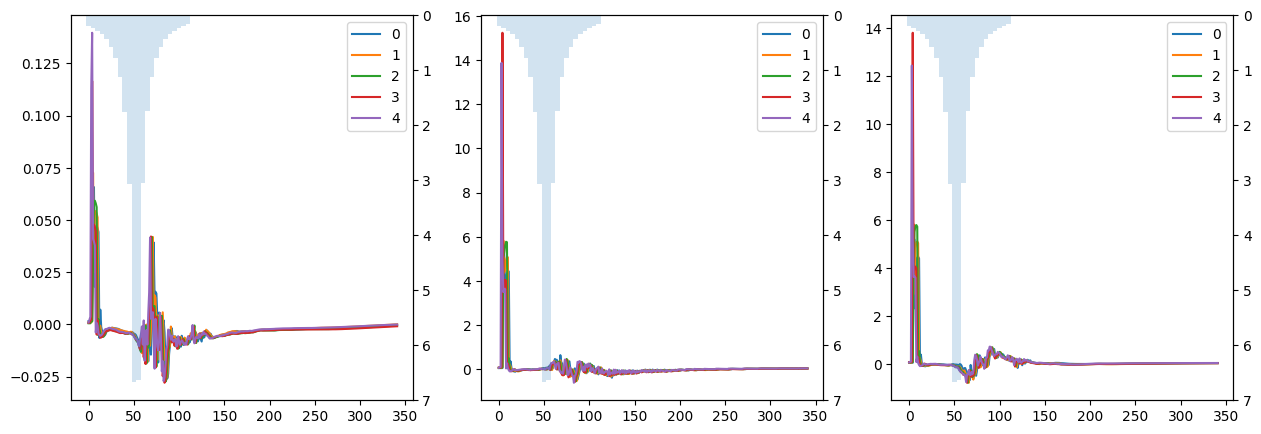

In [265]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(5):
        ax.plot(pred.mean(axis=2)[:,j,i]-true.mean(axis=2)[:,j,i],label=j)
    ax.legend()
    ax2 = ax.twinx()
    ax2.invert_yaxis()
    ax2.bar(rain_ind,rain,width=5,alpha=0.2)

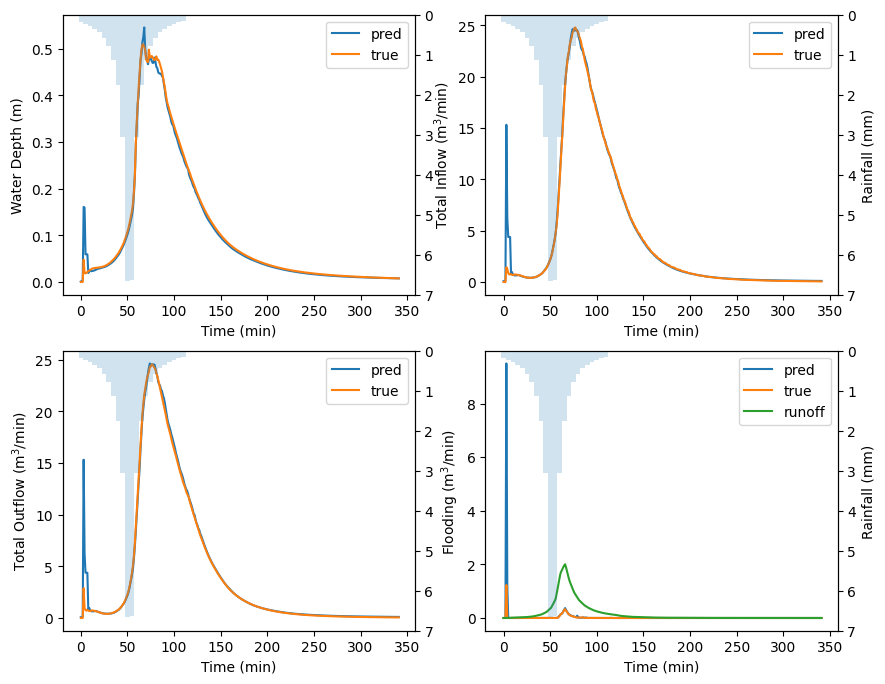

In [266]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,8))
seq = -1
axes = [ax1,ax2,ax3,ax4]
titles = ['Water Depth (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    if idx == len(axes) - 1:
        idx = -1
    ax.plot(pred[:,seq,...].mean(axis=1)[:,idx],label='pred')
    ax.plot(true[:,seq,...].mean(axis=1)[:,idx],label='true')
    if idx == -1:
        ax.plot(r[:,seq,...].mean(axis=1),label='runoff')
    ax.legend()
    ax.set_ylabel(title)
    ax.set_xlabel('Time (min)')
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=5,alpha=0.2)
    if idx in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')

In [268]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],true.shape[-1]))
for i in [0,1,2,-1]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[...,i],y_pred[...,i],squared=False) if metric == 'RMSE' else metric(y_true[...,i],y_pred[...,i])
results.loc['R2','Total inflow'] = metric(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6],y_pred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6])
results.loc['R2','Flooding'] = metric(y_true[...,-1][:,np.abs(y_true[...,-1]).max(axis=0)>1e-6],y_pred[...,-1][:,np.abs(y_true[...,-1]).max(axis=0)>1e-6])
results


,Water depth,Total inflow,Total outflow,Flooding
RMSE,0.002672,16.470682,18.493781,7.011409
MAE,0.00958,0.318667,0.340802,0.014634
R2,0.835574,0.79228,0.742047,-160794.922361


In [231]:
y_true = true[:,-1,:,-1][:,np.abs(true[:,-1,:,-1]).max(axis=0)>1e-6]
y_pred = pred[:,-1,:,-1][:,np.abs(true[:,-1,:,-1]).max(axis=0)>1e-6]
r2(y_true,y_pred,force_finite=False)

-372382.50516764284

In [192]:
y_true,y_pred

(array([2.11885936e+02, 3.25502215e+02, 7.29007945e+00, 5.90687479e-02,
        5.98859581e-03, 1.55934885e-02, 7.35864643e-01, 9.92419603e-03,
        1.13342178e-02, 8.35357866e-03, 1.30828800e-01, 1.97637071e-02,
        3.22254268e-02, 3.35480476e-02, 2.41705983e+00, 1.26648860e-02,
        7.47590406e-02, 1.73757234e-03, 2.98041677e-02, 8.59567256e-01,
        4.24708658e-02, 6.94502413e-02, 8.64882286e-03, 7.08534517e-01,
        5.69972525e-02, 2.92977014e-02, 1.41162748e-01, 6.38459498e-01,
        4.18886409e+00, 1.46106497e-01, 2.36358911e-02, 1.76817498e+00,
        3.16510547e-02, 1.24383501e+00, 3.61619702e-02, 3.49381450e-01,
        7.56080814e-01, 3.25421276e-02, 1.15983485e-01, 7.71014791e-02,
        1.20695003e-01, 1.91521611e+00, 1.17657985e+00, 1.19812657e-02,
        8.99075827e-03, 9.09030026e-01, 2.49473353e+00, 9.28694461e-03,
        2.06234970e-02, 1.56647552e+00, 7.40797153e-02, 3.34736692e+00,
        5.89636827e+00, 1.08723336e+00, 2.56461795e-02, 2.900914

In [200]:
y_true = true[:,-1,:,-1][true[:,-1,:,-1]>0]
y_pred = pred[:,-1,:,-1][true[:,-1,:,-1]>0]
r2(y_true,y_pred,force_finite=False)

-5.35662092290301

In [202]:
numerator = ((y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
numerator

980358.0722350598

In [193]:
denominator = (
        (y_true - np.average(y_true, axis=0)) ** 2
    ).sum(axis=0, dtype=np.float64)
denominator

154196.94128620284

In [270]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/RedChicoSur/RedChicoSur.inp')
nodes = [k for k in list(inp.JUNCTIONS)+list(inp.OUTFALLS)]
idx = nodes.index('DESC')

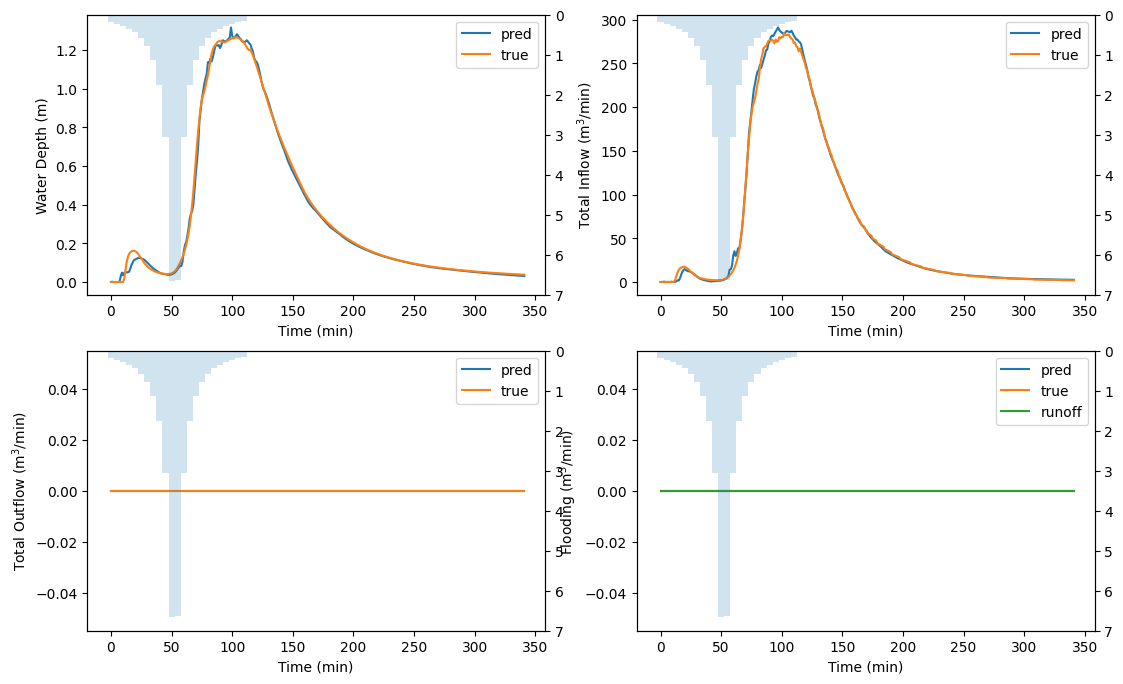

In [271]:
seq = -1

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(13,8))
axes = [ax1,ax2,ax3,ax4]
titles = ['Water Depth (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']

for i,(ax,title) in enumerate(zip(axes,titles)):
    if i == len(axes) - 1:
        i = -1
    ax.plot(pred[:,seq,idx,i],label='pred')
    ax.plot(true[:,seq,idx,i],label='true')
    if i == - 1:
        ax.plot(r[:,seq,idx,0],label='runoff')
    ax.legend()
    ax.set_ylabel(title)
    ax.set_xlabel('Time (min)')
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=5,alpha=0.2)
    if idx in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')

In [272]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],true.shape[-1]))
for i in [0,1,2,-1]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[:,idx,i],y_pred[:,idx,i],squared=False) if metric == 'RMSE' else metric(y_true[:,idx,i],y_pred[:,idx,i])
results.loc['R2','Total inflow'] = metric(y_true[:,idx,1][:,np.abs(y_true[:,idx,1]).max(axis=0)>1e-6],y_pred[:,idx,1][:,np.abs(y_true[:,idx,1]).max(axis=0)>1e-6])
results

,Water depth,Total inflow,Total outflow,Flooding
RMSE,0.000365,16.14926,0.0,0.0
MAE,0.012063,2.108117,0.0,0.0
R2,0.997822,0.998133,1.0,1.0


### Edge

In [282]:
event = 'train_0'
true = np.load(os.path.join(cwd,event+'_edge_true.npy'))
pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
err = true - pred
err.shape

(342, 5, 444, 3)

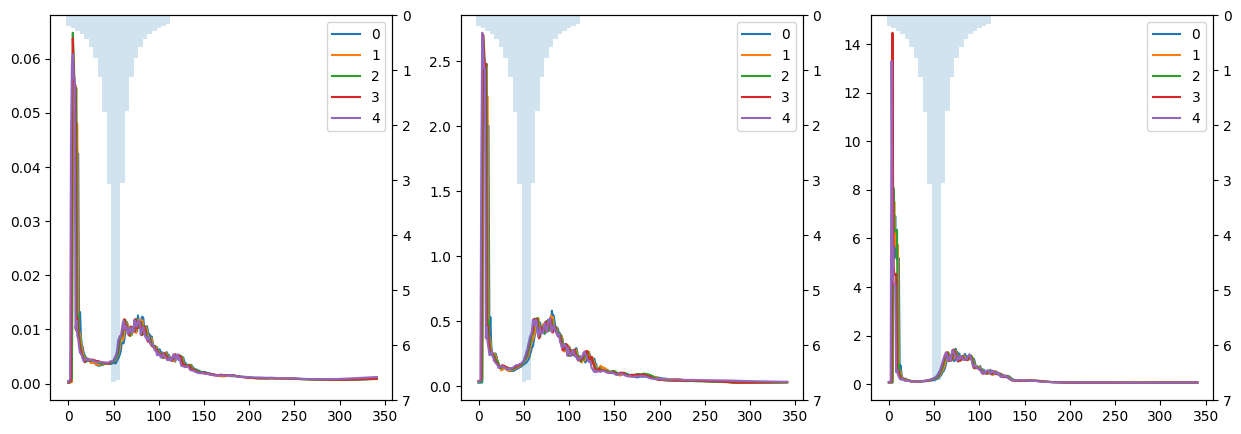

In [283]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()
    ax2 = ax.twinx()
    ax2.invert_yaxis()
    ax2.bar(rain_ind,rain,width=5,alpha=0.2)

Text(0, 0.5, 'Rainfall (mm/5min)')

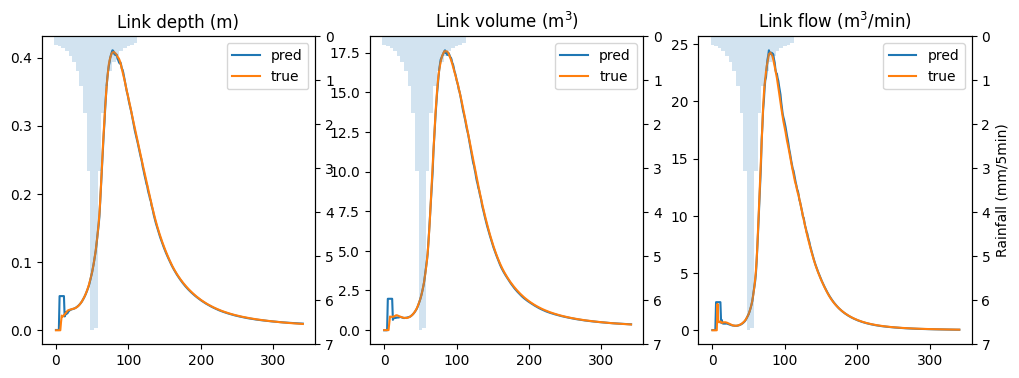

In [284]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
seq = 0

axes,titles = [ax1,ax2,ax3],['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']

for idx,(ax,title) in enumerate(zip(axes,titles)):
    ax.plot(pred[:,seq,...].mean(axis=1)[:,idx],label='pred')
    ax.plot(true[:,seq,...].mean(axis=1)[:,idx],label='true')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=5,alpha=0.2)
axx.set_ylabel('Rainfall (mm/5min)')

In [287]:
columns = ['Link depth','Link volume','Link flow']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],true.shape[-1]))
for i in [0,1,2]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[...,i],y_pred[...,i],squared=False) if metric == 'RMSE' else metric(y_true[...,i],y_pred[...,i])
results.loc['R2','Link depth'] = r2(y_true[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-3],y_pred[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-3])
results.loc['R2','Link volume'] = r2(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-3],y_pred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-3])
results.loc['R2','Link flow'] = r2(y_true[...,2][:,np.abs(y_true[...,2]).max(axis=0)>1e-3],y_pred[...,2][:,np.abs(y_true[...,2]).max(axis=0)>1e-3])
results

,Link depth,Link volume,Link flow
RMSE,0.000302,1.319606,16.602732
MAE,0.003858,0.168091,0.348012
R2,0.948623,0.905508,0.700236


In [279]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/RedChicoSur/RedChicoSur.inp')
links = [k for k in list(inp.CONDUITS)+list(inp.ORIFICES)]
idx = links.index('PLT85829')


Text(0, 0.5, 'Rainfall (mm/5min)')

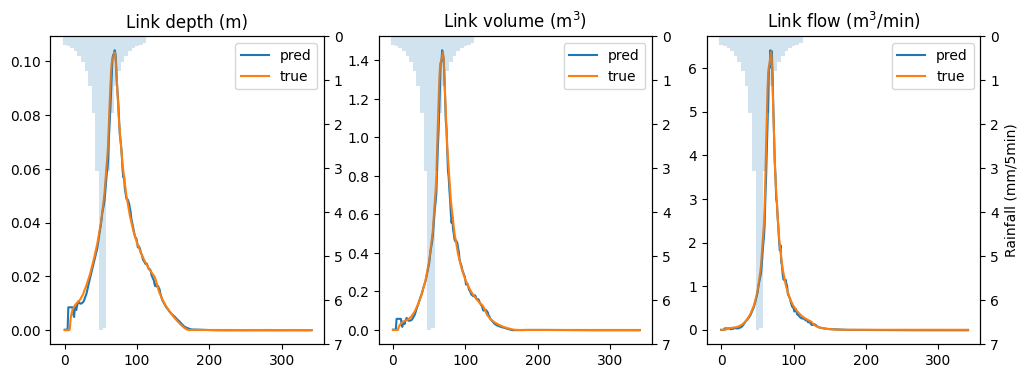

In [280]:
seq = 0

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))

axes,titles = [ax1,ax2,ax3],['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']

for i,(ax,title) in enumerate(zip(axes,titles)):
    ax.plot(pred[:,seq,idx,i],label='pred')
    ax.plot(true[:,seq,idx,i],label='true')
    ax.legend()
    ax.set_title(title)
    axx = ax.twinx()
    axx.invert_yaxis()
    axx.bar(rain_ind,rain,width=5,alpha=0.2)
axx.set_ylabel('Rainfall (mm/5min)')

In [281]:
columns = ['Link depth','Link volume','Link flow']
metrics = ['RMSE','MAE','R2']
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],true.shape[-1]))
results = pd.DataFrame(columns = columns)
for i in [0,1,2]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[:,idx,i],y_pred[:,idx,i],squared=False) if metric == 'RMSE' else metric(y_true[:,idx,i],y_pred[:,idx,i])
results


,Link depth,Link volume,Link flow
RMSE,0.000003,0.00044,0.009259
MAE,0.000811,0.009367,0.034699
R2,0.995166,0.994783,0.992968


## Debug

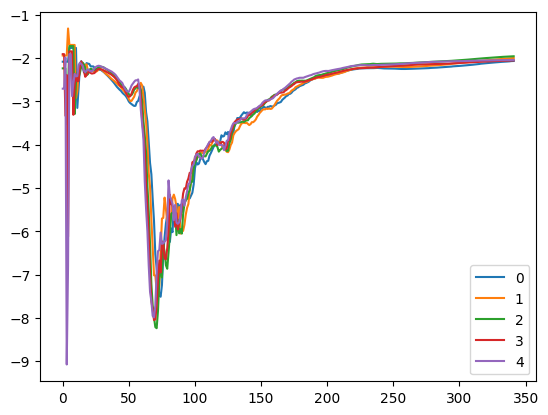

In [94]:
# debug node-edge balance loss
from envs import get_env
from numpy import matmul
event='train_0'
edge_pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))

env = get_env('RedChicoSur')()
env_args = env.get_args()
err = matmul(np.abs(env_args['node_edge']),edge_pred[...,-1:]) - pred[...,1:2] - pred[...,2:3]
for j in range(err.shape[1]):
    plt.plot(err.mean(axis=2)[:,j],label=j)
plt.legend()

## Training

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [9]:
cwd = './model/RedChicoSur/5s_20k_edge_res_norm_flood/'
train_losses = np.load(os.path.join(cwd,'train_loss.npy'))
test_losses = np.load(os.path.join(cwd,'test_loss.npy'))
train_ids = np.load(os.path.join(cwd,'train_id.npy'))
test_ids = np.load(os.path.join(cwd,'test_id.npy'))

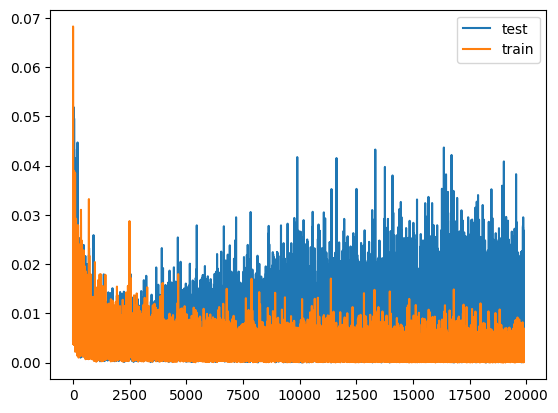

In [10]:
plt.plot(test_losses[100:].sum(axis=1),label='test')
plt.plot(train_losses[100:],label='train')
plt.legend()

# astlingen

## Prediction

In [53]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [54]:
cwd = './results/astlingen/5s_edge_res_norm/'
files = [file for file in os.listdir(cwd) if file.endswith('.npy')]
events = list(set(['_'.join(file.split('_')[:2]) for file in files]))
event = 'astlingen_01_08_2002_19'

In [55]:
inp = read_inp_file('./envs/network/astlingen/'+event+'.inp')
gages = list(inp.RAINGAGES.values())
interval = int(gages[0].Interval.split(':')[0])*60 + int(gages[0].Interval.split(':')[1])
rains = [[dat[-1] for dat in inp.TIMESERIES['rain%s'%(idx+1)].data] for idx in range(len(gages))]
rain_ind = [interval*idx for idx in range(len(rains[0]))]

### Node

In [6]:
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
err = true - pred

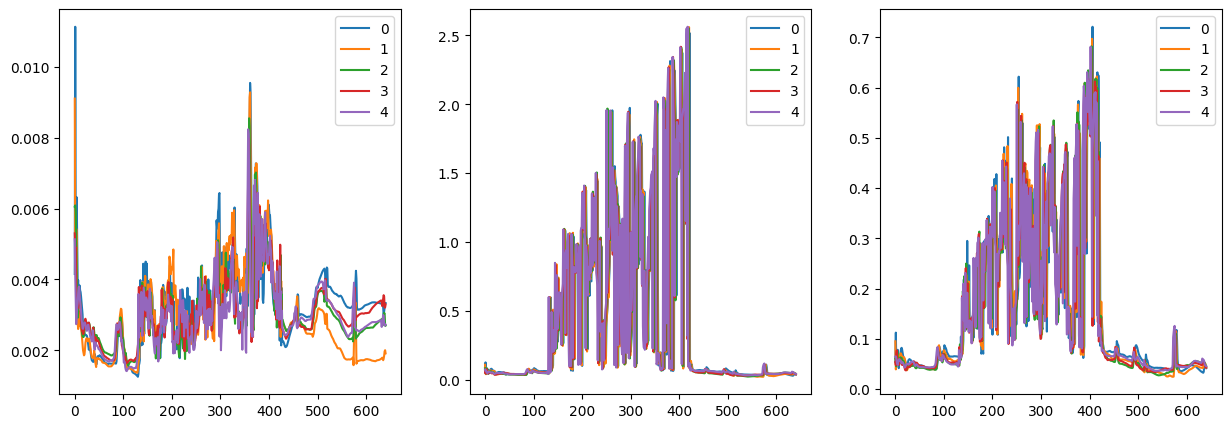

In [373]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()

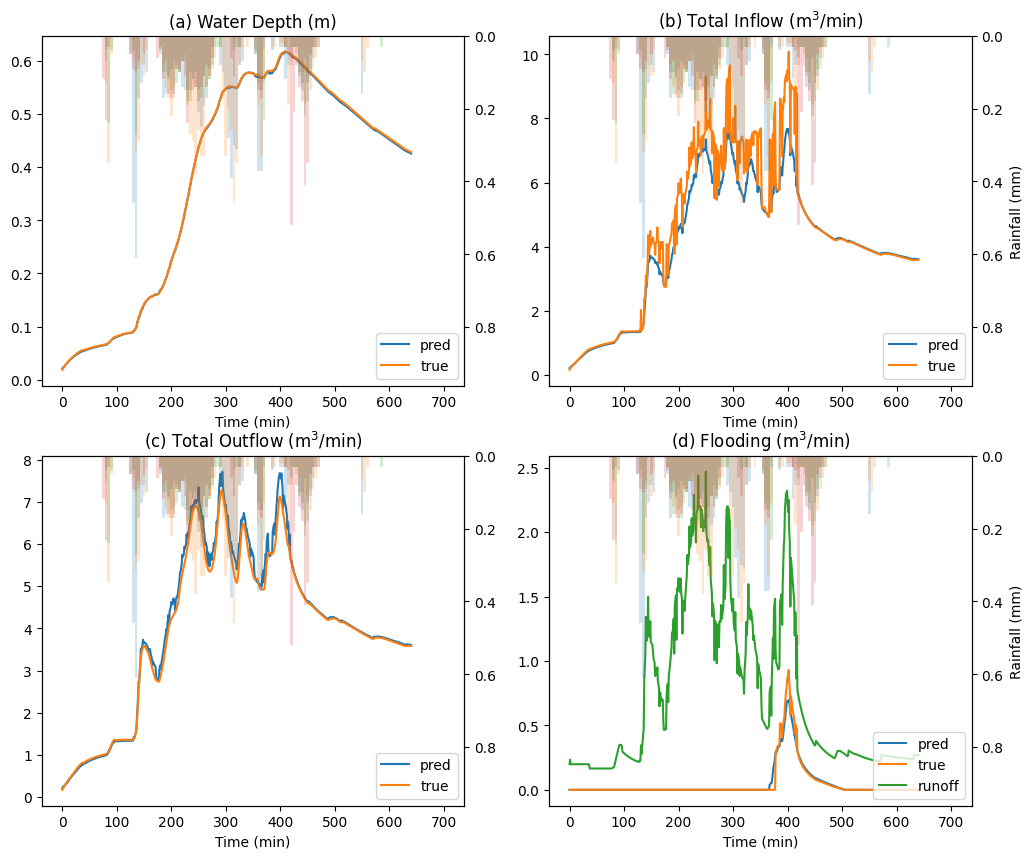

In [374]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,10))
seq = -1

axes = [ax1,ax2,ax3,ax4]
titles = ['Water Depth (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    if idx == len(axes) - 1:
        idx = -1
    ax.plot(pred[:,seq,...].mean(axis=1)[:,idx],label='pred')
    ax.plot(true[:,seq,...].mean(axis=1)[:,idx],label='true')
    if idx == -1:
        ax.plot(r[:,seq,...].mean(axis=1),label='runoff')
    ax.set_xlabel('Time (min)')
    ax.set_title('(%s) '%'abcd'[idx]+title)
    axx = ax.twinx()
    axx.invert_yaxis()
    for j,rain in enumerate(rains):
        axx.bar(rain_ind,rain,width=5,alpha=0.2,label='rain%s'%(j+1))
    ax.legend(loc='lower right')
    if idx in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')
    axx.set_ylim(axx.get_ylim()[0]*1.5,0)


In [375]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],true.shape[-1]))
for i in [0,1,2,-1]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[...,i],y_pred[...,i],squared=False) if metric == 'RMSE' else metric(y_true[...,i],y_pred[...,i])
# results.loc['R2','Total inflow'] = metric(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6],y_pred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-6])
# results.loc['R2','Flooding'] = metric(y_true[...,-1][:,np.abs(y_true[...,-1]).max(axis=0)>1e-6],y_pred[...,-1][:,np.abs(y_true[...,-1]).max(axis=0)>1e-6])
results


,Water depth,Total inflow,Total outflow,Flooding
RMSE,0.000039,1.377363,0.136769,0.033402
MAE,0.00305,0.433938,0.159737,0.009204
R2,0.993921,0.701203,0.988087,0.998252


### Edge

In [362]:
edge_true = np.load(os.path.join(cwd,event+'_edge_true.npy'))
edge_pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
err = edge_true - edge_pred
err.shape

(641, 5, 29, 3)

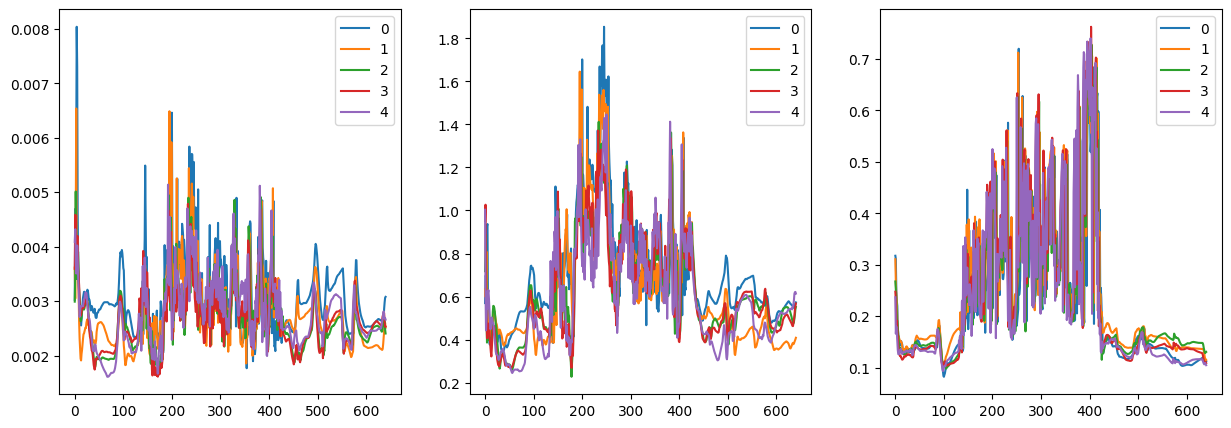

In [363]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()

Text(0, 0.5, 'Rainfall (mm)')

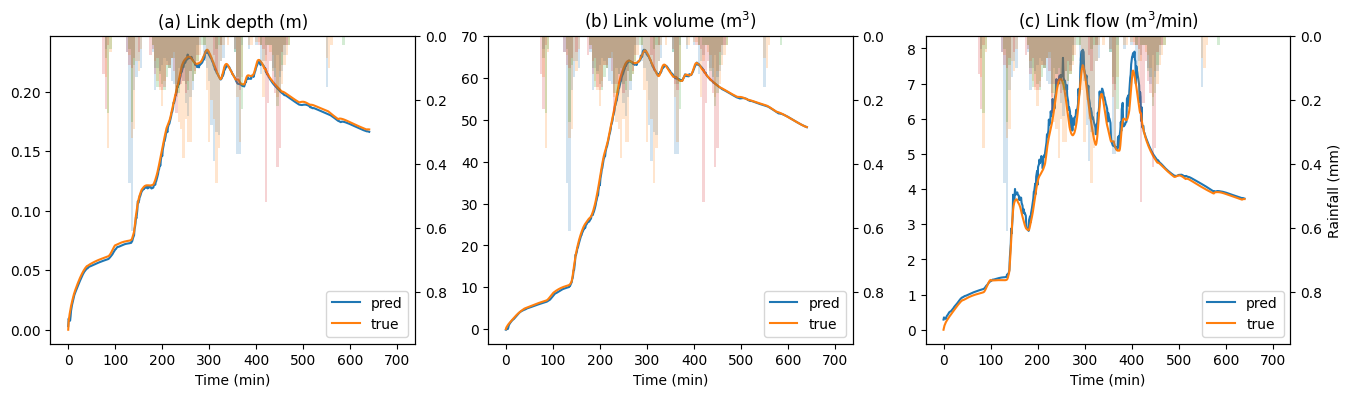

In [364]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))
seq = 0

axes = [ax1,ax2,ax3]
titles = ['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    ax.plot(edge_pred[:,seq,...].mean(axis=1)[:,idx],label='pred')
    ax.plot(edge_true[:,seq,...].mean(axis=1)[:,idx],label='true')
    ax.set_xlabel('Time (min)')
    ax.set_title('(%s) '%'abc'[idx]+title)
    axx = ax.twinx()
    axx.invert_yaxis()
    for j,rain in enumerate(rains):
        axx.bar(rain_ind,rain,width=5,alpha=0.2,label='rain%s'%(j+1))
    ax.legend(loc='lower right')
    axx.set_ylim(axx.get_ylim()[0]*1.5,0)
axx.set_ylabel('Rainfall (mm)')


In [365]:
columns = ['Link depth','Link volume','Link flow']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(edge_true,(-1,edge_true.shape[-2],edge_true.shape[-1]))
y_pred = np.reshape(edge_pred,(-1,edge_pred.shape[-2],edge_pred.shape[-1]))
for i in [0,1,2]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[...,i],y_pred[...,i],squared=False) if metric == 'RMSE' else metric(y_true[...,i],y_pred[...,i])
results.loc['R2','Link depth'] = r2(y_true[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-3],y_pred[...,0][:,np.abs(y_true[...,0]).max(axis=0)>1e-3])
results.loc['R2','Link volume'] = r2(y_true[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-3],y_pred[...,1][:,np.abs(y_true[...,1]).max(axis=0)>1e-3])
results.loc['R2','Link flow'] = r2(y_true[...,2][:,np.abs(y_true[...,2]).max(axis=0)>1e-3],y_pred[...,2][:,np.abs(y_true[...,2]).max(axis=0)>1e-3])
results

,Link depth,Link volume,Link flow
RMSE,0.00002,2.00314,0.244346
MAE,0.002788,0.639,0.238171
R2,0.982037,0.993096,0.965023


In [353]:
y_true.shape

(6370, 29, 3)

### Element-level

In [11]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/astlingen/astlingen.inp')
nodes = [k for k in list(inp.JUNCTIONS)+list(inp.OUTFALLS)+list(inp.STORAGE)]
links = [k for k in list(inp.CONDUITS)+list(inp.ORIFICES)]

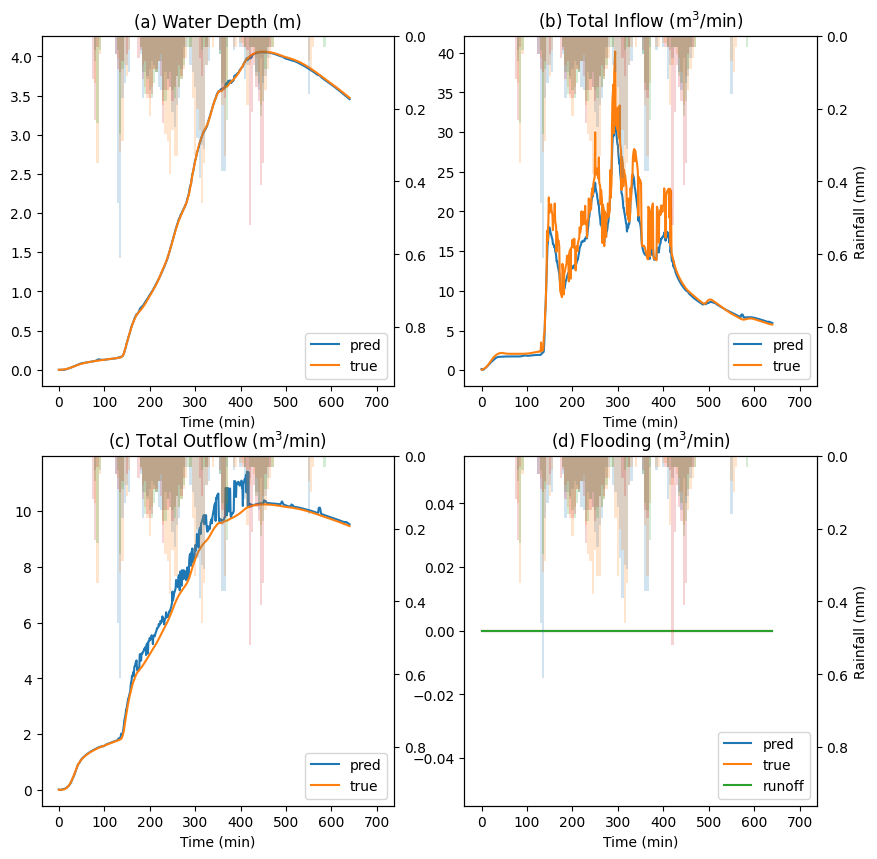

In [14]:
idx = nodes.index('T3')
seq = -1

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))

axes = [ax1,ax2,ax3,ax4]
titles = ['Water Depth (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for i,(ax,title) in enumerate(zip(axes,titles)):
    if i == len(axes) - 1:
        i = -1
    ax.plot(pred[:,seq,idx,i],label='pred')
    ax.plot(true[:,seq,idx,i],label='true')
    if i == -1:
        ax.plot(r[:,seq,idx,0],label='runoff')
    axylim = ax.get_ylim()
    # if max([abs(lim) for lim in axylim]) < 0.1:
    #     ax.set_ylim(axylim[0]*100,axylim[1]*100)
    ax.set_xlabel('Time (min)')
    ax.set_title('(%s) '%'abcd'[i]+title)
    axx = ax.twinx()
    axx.invert_yaxis()
    for j,rain in enumerate(rains):
        axx.bar(rain_ind,rain,width=5,alpha=0.2,label='rain%s'%(j+1))
    ax.legend(loc='lower right')
    if i in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')
    axx.set_ylim(axx.get_ylim()[0]*1.5,0)
    

In [326]:
columns = ['Water depth','Total inflow','Total outflow','Flooding']
metrics = ['RMSE','MAE','R2']
results = pd.DataFrame(columns = columns)
y_true = np.reshape(true,(-1,true.shape[-2],true.shape[-1]))
y_pred = np.reshape(pred,(-1,pred.shape[-2],pred.shape[-1]))
for i in [0,1,2,-1]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[:,idx,i],y_pred[:,idx,i],squared=False) if metric == 'RMSE' else metric(y_true[:,idx,i],y_pred[:,idx,i])
results.loc['R2','Total inflow'] = metric(y_true[:,idx,1][:,np.abs(y_true[:,idx,1]).max(axis=0)>1e-6],y_pred[:,idx,1][:,np.abs(y_true[:,idx,1]).max(axis=0)>1e-6])
results

,Water depth,Total inflow,Total outflow,Flooding
RMSE,0.004349,17.499983,0.127656,0.0
MAE,0.052139,3.06321,0.236787,0.0
R2,0.998411,0.75726,0.991065,1.0


Text(0, 0.5, 'Rainfall (mm)')

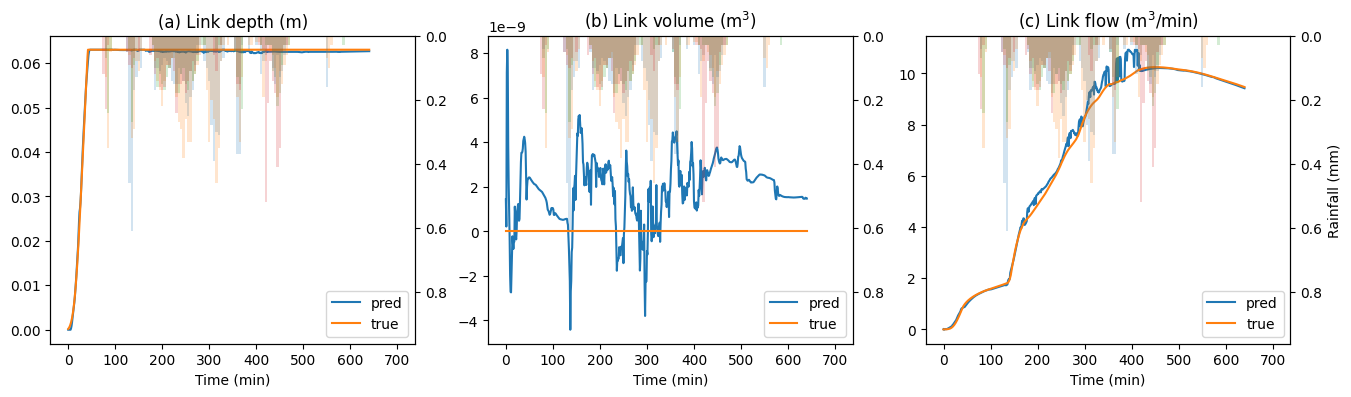

In [367]:
seq = -1
idx = links.index('V3')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))

axes = [ax1,ax2,ax3]
titles = ['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']
for i,(ax,title) in enumerate(zip(axes,titles)):
    ax.plot(edge_pred[:,seq,idx,i],label='pred')
    ax.plot(edge_true[:,seq,idx,i],label='true')
    ax.set_xlabel('Time (min)')
    ax.set_title('(%s) '%'abc'[i]+title)
    axx = ax.twinx()
    axx.invert_yaxis()
    for j,rain in enumerate(rains):
        axx.bar(rain_ind,rain,width=5,alpha=0.2,label='rain%s'%(j+1))
    ax.legend(loc='lower right')
    axx.set_ylim(axx.get_ylim()[0]*1.5,0)
axx.set_ylabel('Rainfall (mm)')

In [368]:
columns = ['Link depth','Link volume','Link flow']
metrics = ['RMSE','MAE','R2']
y_true = np.reshape(edge_true,(-1,edge_true.shape[-2],edge_true.shape[-1]))
y_pred = np.reshape(edge_pred,(-1,edge_pred.shape[-2],edge_pred.shape[-1]))
results = pd.DataFrame(columns = columns)
for i in [0,1,2]:
    for j,metric in enumerate([mse,mae,r2]):
        results.loc[metrics[j],columns[i]] = metric(y_true[:,idx,i],y_pred[:,idx,i],squared=False) if metric == 'RMSE' else metric(y_true[:,idx,i],y_pred[:,idx,i])
results

,Link depth,Link volume,Link flow
RMSE,0.0,0.0,0.082141
MAE,0.000373,0.0,0.172401
R2,0.998398,0.0,0.993798


### Flooding comparison

In [56]:
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
edge_true = np.load(os.path.join(cwd,event+'_edge_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
edge_pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
fpred = np.load(os.path.join(cwd.replace('_norm','_norm_flood'),event+'_pred.npy'))
edge_fpred = np.load(os.path.join(cwd.replace('_norm','_norm_flood'),event+'_edge_pred.npy'))

FileNotFoundError: [Errno 2] No such file or directory: './results/astlingen/5s_edge_res_norm_flood/astlingen_01_08_2002_19_pred.npy'

### Train loss

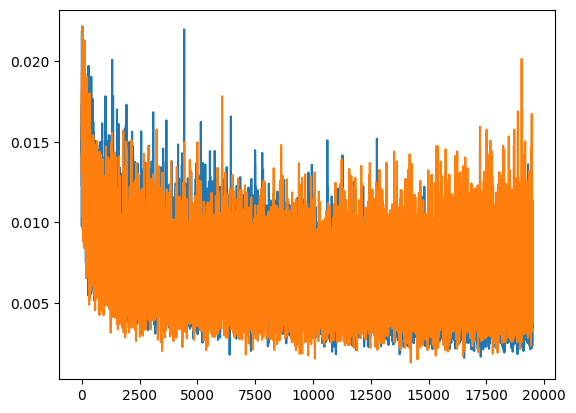

In [5]:
train_losses = np.load('./model/astlingen/10s_20k_act_edge_res_norm_flood/train_loss.npy')
test_losses = np.load('./model/astlingen/10s_20k_act_edge_res_norm_flood/test_loss.npy')
plt.plot(train_losses[500:20000])
plt.plot([sum(los) for los in test_losses[500:20000]])

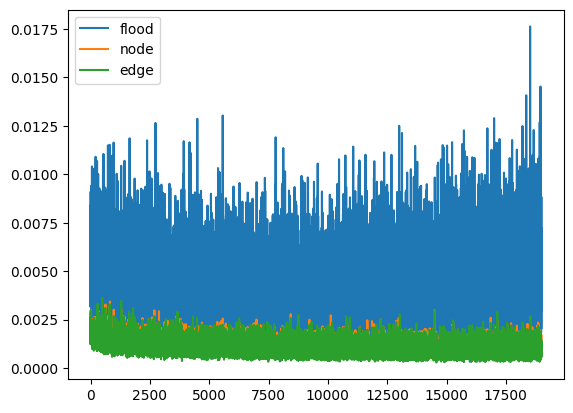

In [7]:
plt.plot([[los[1],los[0],los[2]] for los in test_losses[1000:]],label=['flood','node','edge'])
plt.legend()

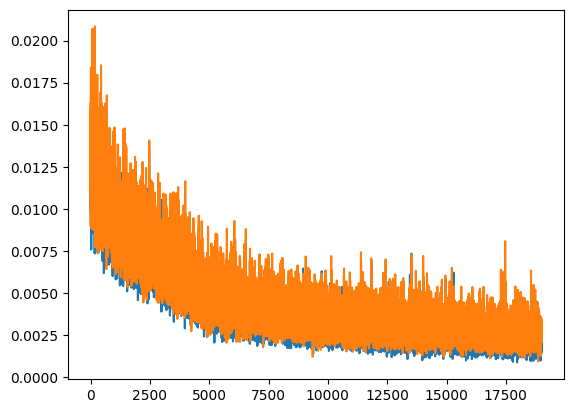

In [4]:
train_losses = np.load('./model/astlingen/10s_20k_res_norm_flood/train_loss.npy')
test_losses = np.load('./model/astlingen/10s_20k_res_norm_flood/test_loss.npy')
plt.plot(train_losses[1000:20000])
plt.plot([sum(los) for los in test_losses[1000:20000]])

### Debug

In [110]:
from envs import get_env
env = get_env('astlingen')()
env_args = env.get_args()
node_edge = env_args['node_edge']

In [120]:
edge_true = np.load('./results/astlingen/5s_edge_res_norm_flood/astlingen_02_08_2002_21_edge_true.npy')
true = np.load('./results/astlingen/5s_edge_res_norm_flood/astlingen_02_08_2002_21_true.npy')
node_outflow = np.matmul(np.clip(node_edge,0,1),np.clip(edge_true[...,-1:],0,np.inf)) + np.matmul(np.abs(np.clip(node_edge,-1,0)),-np.clip(edge_true[...,-1:],-np.inf,0))
node_inflow = np.matmul(np.abs(np.clip(node_edge,-1,0)),np.clip(edge_true[...,-1:],0,np.inf)) + np.matmul(np.clip(node_edge,0,1),-np.clip(edge_true[...,-1:],-np.inf,0))

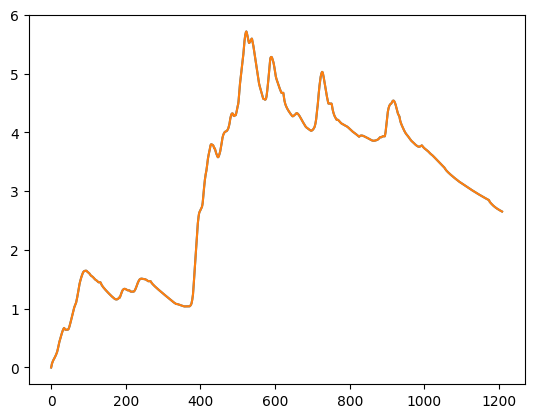

In [121]:
plt.plot(node_outflow[:,0,:,0].mean(axis=1))
plt.plot(true[:,0,:,2].mean(axis=1))

In [115]:
edge_pred = np.load('./results/astlingen/5s_edge_res_norm_flood/astlingen_02_08_2002_21_edge_pred.npy')
pred = np.load('./results/astlingen/5s_edge_res_norm_flood/astlingen_02_08_2002_21_pred.npy')
node_outflow = np.matmul(np.clip(node_edge,0,1),np.clip(edge_pred[...,-1:],0,np.inf)) + np.matmul(np.abs(np.clip(node_edge,-1,0)),-np.clip(edge_pred[...,-1:],-np.inf,0))
node_inflow = np.matmul(np.abs(np.clip(node_edge,-1,0)),np.clip(edge_pred[...,-1:],0,np.inf)) + np.matmul(np.clip(node_edge,0,1),-np.clip(edge_pred[...,-1:],-np.inf,0))

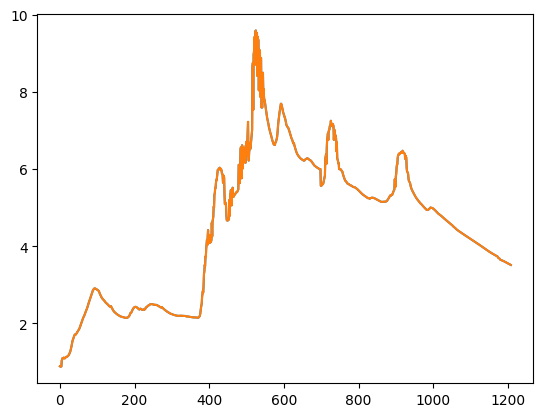

In [116]:
plt.plot(node_outflow[:,0,:,0].mean(axis=1))
plt.plot(pred[:,0,:,2].mean(axis=1))

In [134]:
env.get_features('links')

['C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C2',
 'C20',
 'C21',
 'C22',
 'C23',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6']

### Rainfalls

In [127]:
import pandas as pd
rain = pd.read_csv('./envs/config/ast_rain_events.csv',index_col=0)
rain = rain[rain['Precipitation'].apply(lambda x:5<x<15)]
train = rain[rain['Date'].apply(lambda x:eval(x[-1])<7)]
test = rain[rain['Date'].apply(lambda x:eval(x[-1])>6)]
train.to_csv('./envs/config/ast_train_events.csv')
test.to_csv('./envs/config/ast_test_events.csv')

## MPC Test

In [1]:
from emulator import Emulator
from envs import astlingen
import yaml,argparse,os,time
import numpy as np
import multiprocessing as mp
from mpc import get_runoff
from utilities import get_inp_files
from swmm_api import read_inp_file
import matplotlib.pyplot as plt

c:\Users\chong\anaconda3\envs\storm\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cwd = '10s_20k_act_edgef_res_norm_flood_roll'
result_dir = '10s_20k_rand_edgef_res_norm_flood_roll'
hyps = yaml.load(open('config.yaml','r'),yaml.FullLoader)
args = argparse.Namespace(**hyps['astlingen'])
args.model_dir = os.path.join(args.model_dir,cwd)
args.result_dir = os.path.join(args.result_dir,result_dir)
known_hyps = yaml.load(open(os.path.join(args.model_dir,'parser.yaml'),'r'),yaml.FullLoader)
env = astlingen()
env_args = env.get_args()
for k,v in list(known_hyps.items())+list(env_args.items()):
    if k == 'model_dir':
        continue
    setattr(args,k,v)
args.use_edge = args.use_edge or args.edge_fusion
args.n_step,args.r_step = args.prediction['control_horizon']//args.control_interval,args.control_interval//args.interval
emul = Emulator(args.conv,args.resnet,args.recurrent,args)
emul.load(args.model_dir)

if not os.path.exists(args.result_dir):
    os.mkdir(args.result_dir)

In [3]:
event = get_inp_files(env.config['swmm_input'],env.config['rainfall'])[0]
name = os.path.basename(event).strip('.inp')
runoff = get_runoff(env,event,rate=False)
horizon = args.prediction['eval_horizon']//args.interval
runoff = np.stack([np.concatenate([runoff[idx:idx+horizon],np.tile(np.zeros_like(s),(max(idx+horizon-runoff.shape[0],0),)+tuple(1 for _ in s.shape))],axis=0)
                    for idx,s in enumerate(runoff)])

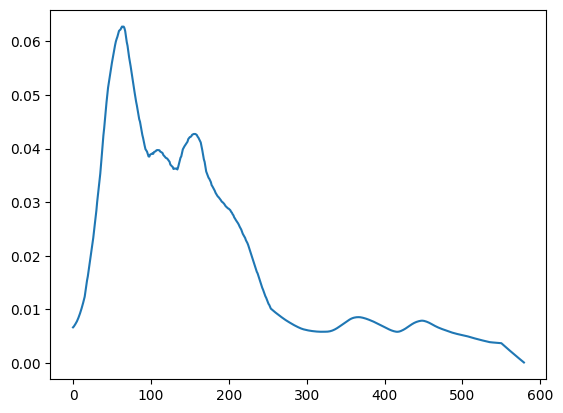

In [8]:
# Cumulative lateral flow result
plt.plot(runoff[...,-1].mean(axis=-1).mean(axis=-1)/60)

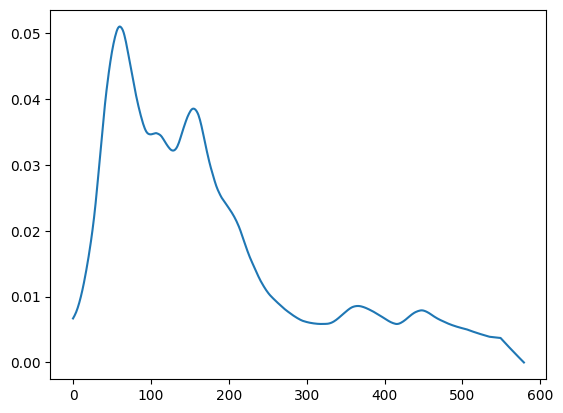

In [6]:
# Lateral flow rate result
plt.plot(runoff[...,-1].mean(axis=-1).mean(axis=-1))

### Rolling prediction for MPC (60 mins with 10 seq_out)

In [49]:
state = env.reset(event,global_state=True,seq=args.seq_in)
perf = env.performance(seq=args.seq_in)
states,perfs = [state[-1]],[perf[-1]]
edge_state = env.state_full(typ='links',seq=args.seq_in)
edge_states = [edge_state[-1]]
setting = [1 for _ in env.config['action_space']]
settings = [setting]
preds = []
done,i = False,0
while not done:
    if i*args.interval % args.prediction['control_horizon'] == 0:
        j = 0
        setting = np.array([[env.controller(mode='bc')
         for _ in range(args.n_step)]])
        setting = np.concatenate([np.repeat(setting[:,i:i+1,:],args.r_step,axis=1)
                                   for i in range(setting.shape[1])],axis=1)
        if setting.shape[1] < args.prediction['eval_horizon']:
            setting = np.concatenate([setting,np.repeat(setting[:,-1:,:],args.prediction['eval_horizon']-setting.shape[1],axis=1)],axis=1)
        if args.if_flood:
            f = (perf>0).astype(int)
            f = np.eye(2)[f].squeeze(-2)
            state = np.concatenate([state,f],axis=-1)

        state = np.expand_dims(state,0)
        r = np.expand_dims(runoff[i],0)
        edge_state = np.expand_dims(edge_state,0)
        pred = emul.predict(state,r,setting,edge_state if args.use_edge else None)
        preds.append(pred)

    done = env.step(setting[0,j,:])
    state = env.state(seq=args.seq_in)
    perf = env.performance(seq=args.seq_in)
    edge_state = env.state_full(args.seq_in,'links')
    states.append(state[-1])
    perfs.append(perf[-1])
    edge_states.append(edge_state[-1])
    settings.append(setting[0,j,:])
    i += 1
    j += 1
states,perfs,edge_states,settings = [np.stack(dat,axis=0) for dat in [states,perfs,edge_states,settings]]
if args.use_edge:
    preds,edge_preds = np.concatenate([pred[0][0] for pred in preds],axis=0),np.concatenate([pred[1][0] for pred in preds],axis=0)
else:
    preds = np.concatenate(preds,axis=1)

In [5]:
states.shape,perfs.shape,preds.shape

((581, 30, 4), (581, 30, 1), (600, 30, 6))

In [7]:
runoff.shape

(580, 60, 30, 1)

In [46]:
inp = read_inp_file(event)
gages = list(inp.RAINGAGES.values())
interval = int(gages[0].Interval.split(':')[0])*60 + int(gages[0].Interval.split(':')[1])
rains = [[dat[-1] for dat in inp.TIMESERIES['rain%s'%(idx+1)].data] for idx in range(len(gages))]
rain_ind = [interval*idx for idx in range(len(rains[0]))]

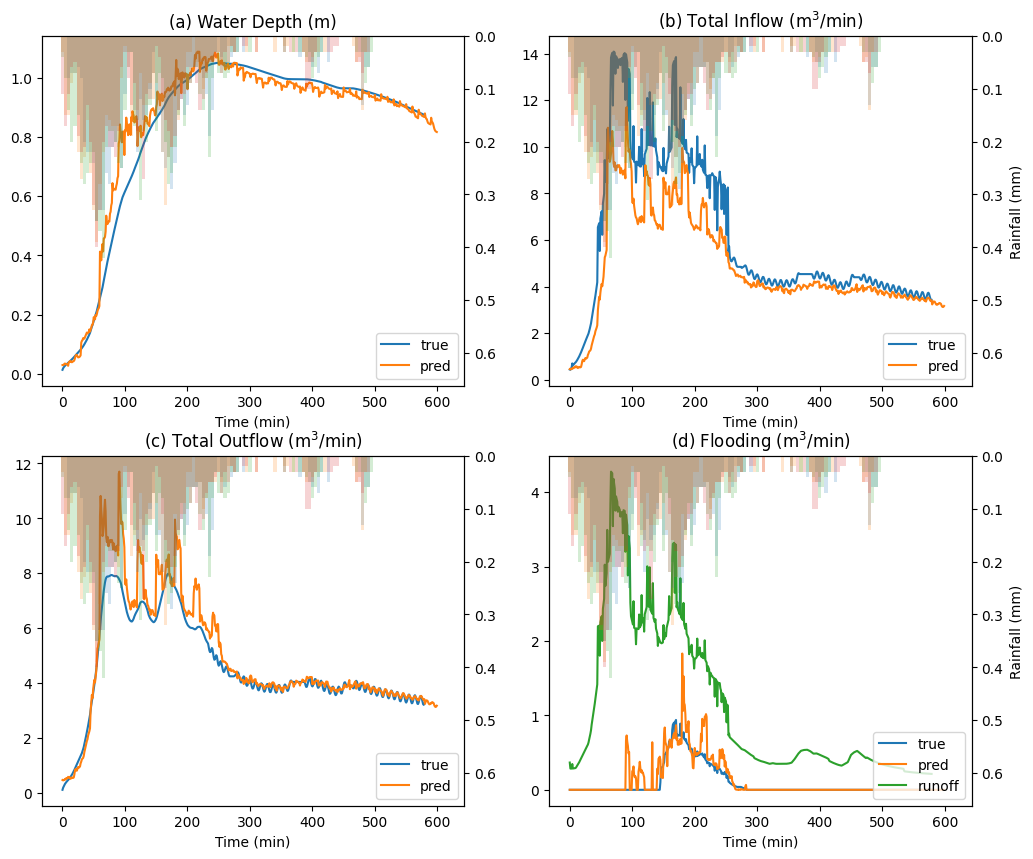

In [50]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,10))

axes = [ax1,ax2,ax3,ax4]
titles = ['Water Depth (m)','Total Inflow ($\mathregular{m^3}$/min)','Total Outflow ($\mathregular{m^3}$/min)','Flooding ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    if idx == len(axes) - 1:
        idx = -1
        ax.plot(perfs[1:,:,0].mean(axis=1),label='true')
    else:
        ax.plot(states[1:,:,idx].mean(axis=1),label='true')
    ax.plot(preds[...,idx].mean(axis=1),label='pred')
    if idx == -1:
        ax.plot(runoff[:,0,...,0].mean(axis=1),label='runoff')
    ax.set_xlabel('Time (min)')
    ax.set_title('(%s) '%'abcd'[idx]+title)
    axx = ax.twinx()
    axx.invert_yaxis()
    for j,rain in enumerate(rains):
        axx.bar(rain_ind,rain,width=5,alpha=0.2,label='rain%s'%(j+1))
    ax.legend(loc='lower right')
    if idx in [1,-1]:
        axx.set_ylabel('Rainfall (mm)')
    axx.set_ylim(axx.get_ylim()[0]*1.5,0)

In [14]:
edge_states.shape,edge_preds.shape

((581, 29, 4), (600, 29, 3))

Text(0, 0.5, 'Rainfall (mm)')

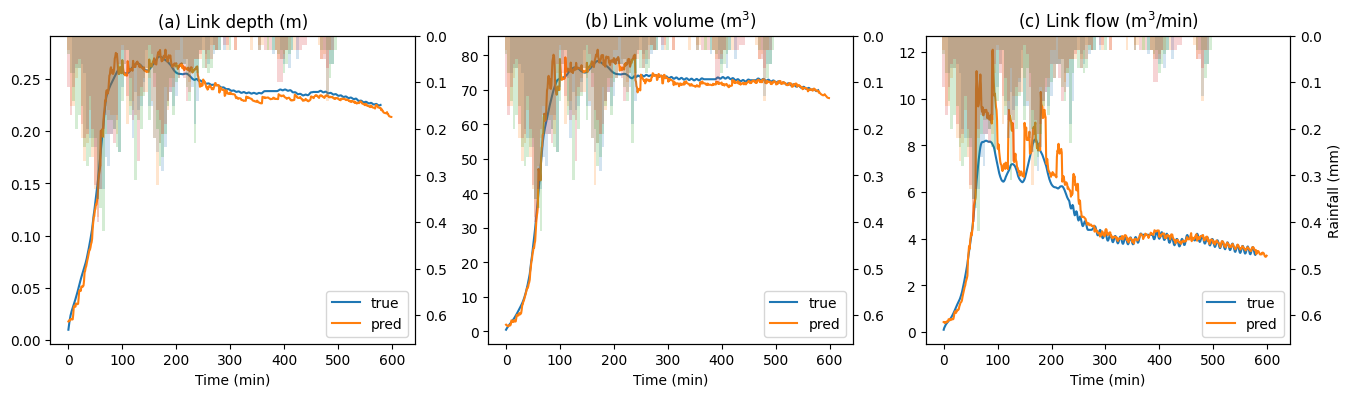

In [51]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))
seq = 0

axes = [ax1,ax2,ax3]
titles = ['Link depth (m)','Link volume ($\mathregular{m^3}$)','Link flow ($\mathregular{m^3}$/min)']
for idx,(ax,title) in enumerate(zip(axes,titles)):
    ax.plot(edge_states[1:,:,idx].mean(axis=1),label='true')
    ax.plot(edge_preds[...,idx].mean(axis=1),label='pred')
    ax.set_xlabel('Time (min)')
    ax.set_title('(%s) '%'abc'[idx]+title)
    axx = ax.twinx()
    axx.invert_yaxis()
    for j,rain in enumerate(rains):
        axx.bar(rain_ind,rain,width=5,alpha=0.2,label='rain%s'%(j+1))
    ax.legend(loc='lower right')
    axx.set_ylim(axx.get_ylim()[0]*1.5,0)
axx.set_ylabel('Rainfall (mm)')

### Predictive evaluation results comparison between SWMM-hsf and surrogate of random actions

TODO: Emulation vs Simulation of random control actions in each time step

In [4]:
from mpc import pred_simu

- Need a subprocess for predictive simulation to avoid distraction
- Multiprocessing doesn't work in jupyter --> define the function in another file

In [27]:
if __name__ == '__main__':
    pop_size = 64
    idx = 0
    state = env.reset(event,global_state=True,seq=args.seq_in)
    perf = env.performance(seq=args.seq_in)
    edge_state = env.state_full(typ='links',seq=args.seq_in)
    # preds,simu_preds = [],[]
    done,i,j = False,0,30

    y = np.array([[[1.0,1.0,1.0,1.0]
    for _ in range(args.n_step)] for _ in range(pop_size)])
    setting = np.concatenate([np.repeat(y[:,i:i+1,:],args.r_step,axis=1)
                            for i in range(y.shape[1])],axis=1)
    if setting.shape[1] < args.prediction['eval_horizon'] // args.interval:
        setting = np.concatenate([setting,np.repeat(setting[:,-1:,:],args.prediction['eval_horizon'] // args.interval - setting.shape[1],axis=1)],axis=1)
    
    while not done:
        # if i*args.interval % args.prediction['control_horizon'] == 0:
        if i == 8 * args.prediction['control_horizon']:
            j,perfs,states,edge_states = 0,[],[],[]
            rrs = []
            if args.if_flood:
                f = (perf>0).astype(int)
                f = np.eye(2)[f].squeeze(-2)
                state = np.concatenate([state[...,:-1],f,state[...,-1:]],axis=-1)
            state = np.repeat(np.expand_dims(state,0),pop_size,axis=0)
            r = np.repeat(np.expand_dims(runoff[i],0),pop_size,axis=0)
            edge_state = np.repeat(np.expand_dims(edge_state,0),pop_size,axis=0)
            t0 = time.time()
            pred = emul.predict(state,r,setting,edge_state if args.use_edge else None)
            t1 = time.time()
            print('emulation time: %s'%(t1-t0))
            # preds.append(pred)

            eval_file = env.get_eval_file(args.prediction['no_runoff'])
            pool = mp.Pool(args.processes)
            res = [pool.apply_async(func=pred_simu,args=(yi,eval_file,args,ri[...,0]/args.interval/60,)) for yi,ri in zip(y,r)]
            # res = [pool.apply_async(func=pred_simu,args=(yi,eval_file,args,ri[...,0],)) for yi,ri in zip(y,r)]
            pool.close()
            pool.join()
            F = [r.get() for r in res]        
            simu_pred = np.stack(F)
            print('hsf simu time: %s'%(time.time()-t1))
            # simu_pred = np.stack([pred_simu(sett,eval_file,args) for sett in setting])
            # simu_preds.append(simu_pred)

        if j < args.prediction['control_horizon']:
            done = env.step(setting[idx,j,:])
            state = env.state()
            states.append(state)
            edge_state = env.state_full(typ='links')
            edge_states.append(edge_state)
            rr = [env.env._getNodeLateralInflow(node) for node in env.elements['nodes']]
            rrs.append(rr)
            perf = env.performance()
            perfs.append(perf)
            j += 1
        else:
            done = env.step()
        state = env.state(seq=args.seq_in)
        perf = env.performance(seq=args.seq_in)
        edge_state = env.state_full(args.seq_in,'links')
        # states.append(state[-1])
        # perfs.append(perf[-1])
        # edge_states.append(edge_state[-1])
        i += 1
        # print('Simulation time: %s'%env.data_log['simulation_time'][-1])
    # states,perfs,edge_states = [np.stack(dat,axis=0) for dat in [states,perfs,edge_states]]
    # if args.use_edge:
    #     preds,edge_preds = np.concatenate([pred[0][0] for pred in preds],axis=0),np.concatenate([pred[1][0] for pred in preds],axis=0)
    # else:
    #     preds = np.concatenate(preds,axis=1)


emulation time: 1.4248058795928955
hsf simu time: 6.438014268875122


In [12]:
pred[0].shape

(64, 30, 30, 6)

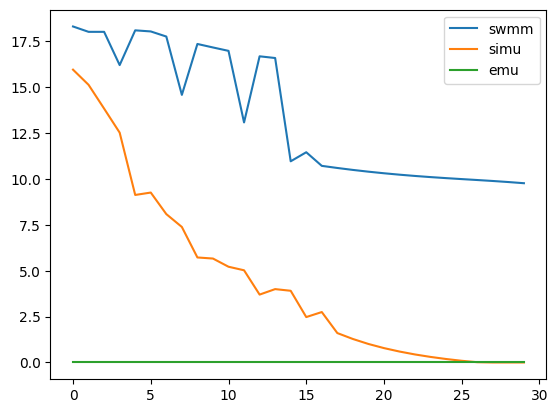

In [28]:
perfs = np.stack(perfs)
emu_perf,simu_perf = pred[0][idx,...,-1],simu_pred[idx,...,0]
plt.plot(perfs[...,0].sum(axis=-1),label='swmm')
plt.plot(simu_perf.sum(axis=-1),label='simu')
plt.plot(emu_perf.sum(axis=-1),label='emu')
plt.legend()

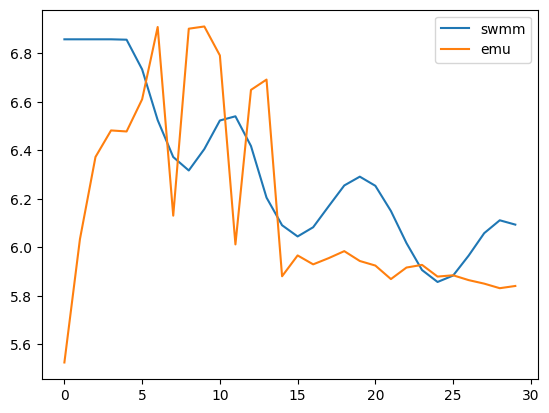

In [8]:
states = np.stack(states)
plt.plot(states[...,2].mean(axis=-1),label='swmm')
plt.plot(pred[0][idx,...,2].mean(axis=-1),label='emu')
plt.legend()

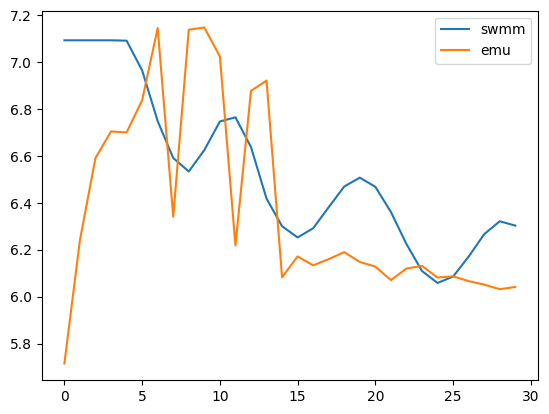

In [9]:
edge_states = np.stack(edge_states)
plt.plot(edge_states[...,2].mean(axis=-1),label='swmm')
plt.plot(pred[1][idx,...,2].mean(axis=-1),label='emu')
plt.legend()

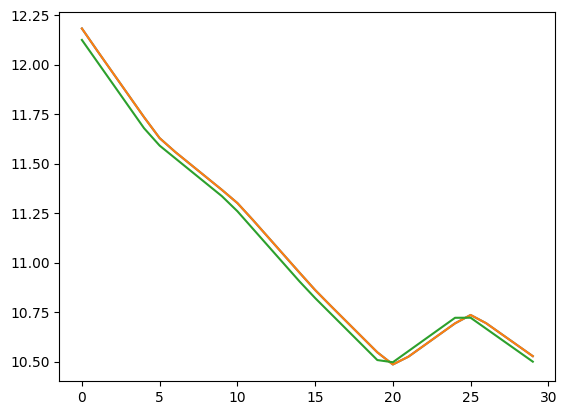

In [22]:
plt.plot(r[0,...,0].sum(axis=-1))
states = np.stack(states)
plt.plot(states[...,-1].sum(axis=-1))
rrs = np.stack(rrs)
plt.plot(rrs.sum(axis=-1)*60)

There are bugs in hotstart files. Maybe the save_hotstart function needs to be fixed for only hydraulic stuff, and lateral inflow show be imported through generate_inflow.

In [59]:
if __name__ == '__main__':
    pop_size = 64
    state = env.reset(event,global_state=True,seq=args.seq_in)
    perf = env.performance(seq=args.seq_in)
    edge_state = env.state_full(typ='links',seq=args.seq_in)
    perfs,preds,simu_preds = [],[],[]
    done,i,j = False,0,30

    y = np.array([[env.controller(mode='rand')
    for _ in range(args.n_step)] for _ in range(pop_size)])
    setting = np.concatenate([np.repeat(y[:,i:i+1,:],args.r_step,axis=1)
                            for i in range(y.shape[1])],axis=1)
    if setting.shape[1] < args.prediction['eval_horizon'] // args.interval:
        setting = np.concatenate([setting,np.repeat(setting[:,-1:,:],args.prediction['eval_horizon'] // args.interval - setting.shape[1],axis=1)],axis=1)
    
    while not done:
        if i*args.interval % args.prediction['control_horizon'] == 0:
            if args.if_flood:
                f = (perf>0).astype(int)
                f = np.eye(2)[f].squeeze(-2)
                state = np.concatenate([state[...,:-1],f,state[...,-1:]],axis=-1)
            state = np.repeat(np.expand_dims(state,0),pop_size,axis=0)
            r = np.repeat(np.expand_dims(runoff[i],0),pop_size,axis=0)
            edge_state = np.repeat(np.expand_dims(edge_state,0),pop_size,axis=0)
            pred = emul.predict(state,r,setting,edge_state if args.use_edge else None)
            preds.append(pred[0][...,-1:])

            eval_file = env.get_eval_file(args.prediction['no_runoff'])
            pool = mp.Pool(args.processes)
            res = [pool.apply_async(func=pred_simu,args=(yi,eval_file,args,ri[...,0]/args.interval/60,)) for yi,ri in zip(y,r)]
            # res = [pool.apply_async(func=pred_simu,args=(yi,eval_file,args,ri[...,0],)) for yi,ri in zip(y,r)]
            pool.close()
            pool.join()
            F = [r.get() for r in res]        
            simu_pred = np.stack(F)
            # simu_pred = np.stack([pred_simu(sett,eval_file,args) for sett in setting])
            simu_preds.append(simu_pred)

        done = env.step()
        state = env.state(seq=args.seq_in)
        perf = env.performance(seq=args.seq_in)
        edge_state = env.state_full(args.seq_in,'links')
        # states.append(state[-1])
        perfs.append(perf[-1])
        # edge_states.append(edge_state[-1])
        i += 1
        # print('Simulation time: %s'%env.data_log['simulation_time'][-1])
    perfs = np.stack(perfs,axis=0)
    # if args.use_edge:
    #     preds,edge_preds = np.concatenate([pred[0][0] for pred in preds],axis=0),np.concatenate([pred[1][0] for pred in preds],axis=0)
    # else:
    #     preds = np.concatenate(preds,axis=1)

In [60]:
simu_perf = np.squeeze(np.stack([pred for pred in simu_preds if pred.shape[1] == args.prediction['eval_horizon']]))
emu_perf = np.squeeze(np.stack(preds[:simu_perf.shape[0]]))
emu_perf.shape

(19, 64, 30, 30)

Text(0, 0.5, 'emu')

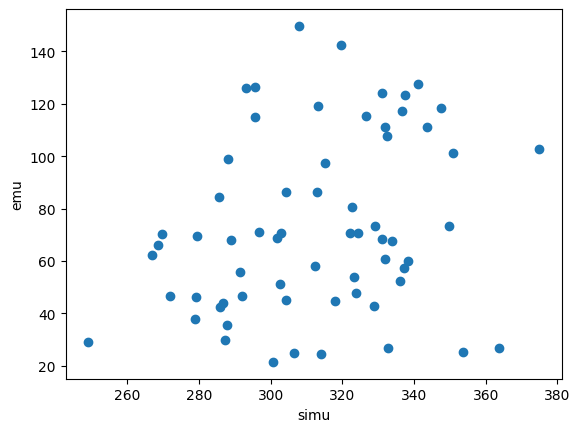

In [61]:
idx = 7
simu,emu = simu_perf[idx,...].sum(axis=-1).sum(axis=-1),emu_perf[idx,...].sum(axis=-1).sum(axis=-1)
plt.scatter(simu,emu)
# ly = lx =np.arange(min(simu.min(),emu.min()),max(simu.max(),emu.max()),10)
# plt.plot(lx,ly,'x--')
plt.xlabel('simu')
plt.ylabel('emu')

## Generate inflow test

Modify the hotstart function for hydraulic predictive modelling, use external hydrological inflow instead of SWMM.

In [31]:
from utilities import get_inp_files
import numpy as np
from envs import astlingen

In [32]:
event = get_inp_files(env.config['swmm_input'],env.config['rainfall'])[0]
env = astlingen(swmm_file = event)
done = False
clis,lis = [],[]
nodes = env.get_features('nodes')
while not done:
    lis.append([env.env._getNodeLateralInflow(n) for n in nodes])
    clis.append([env.env._getNodeLateralInflowVol(n) for n in nodes])
    done = env.step()
lis,clis = np.array(lis),np.array(clis)

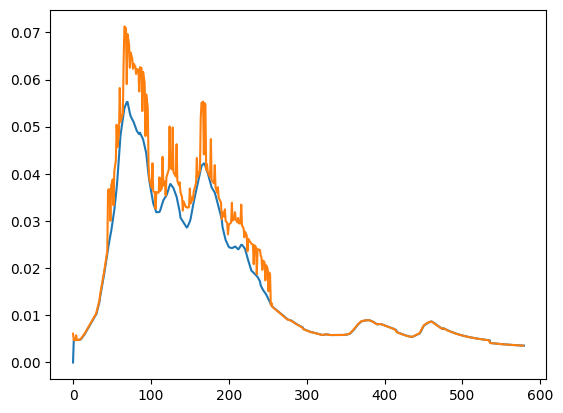

In [38]:
import matplotlib.pyplot as plt
plt.plot(lis.mean(axis=1))
plt.plot(np.diff(clis,axis=0).mean(axis=1)/60)

In [64]:
r.max()/60

0.028940908314719613

In [31]:
from swmm_api import read_inp_file
inp = read_inp_file(event)

In [32]:
inp.pop('DWF')
inp.write_file('test.inp')

'test.inp'